In [914]:
import sys
import json
import torch
from torch import nn
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup, BertForSequenceClassification\
    , BertForPreTraining, AutoModel
from transformers import XLMTokenizer, XLMWithLMHeadModel


from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import random
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, mean_squared_error
import time

In [941]:
from transformers import XLMTokenizer, XLMWithLMHeadModel
tokenizer = XLMTokenizer.from_pretrained("xlm-mlm-100-1280")
model = XLMWithLMHeadModel.from_pretrained("xlm-mlm-100-1280")

Some weights of XLMWithLMHeadModel were not initialized from the model checkpoint at xlm-mlm-100-1280 and are newly initialized: ['transformer.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [942]:
torch.manual_seed(7)
random.seed(7)
np.random.seed(7)
# Setting PyTorch's required configuration variables for reproducibility.
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = False
torch.use_deterministic_algorithms(False)

# choose the model here

In [943]:
#PRE_TRAINED_MODEL = 'bert-base-multilingual-cased'
PRE_TRAINED_MODEL = 'xlm-mlm-100-1280'



In [944]:
MAXTOKENS = 5
NUM_EPOCHS = 2000  # default maximum number of epochs
BERT_EMB = 768  # set to either 768 or 1024 for BERT-Base and BERT-Large models respectively
BS = 8  # batch size
INITIAL_LR = 1e-5  # initial learning rate
save_epochs = [1, 2, 3, 4, 5, 6, 7]  # these are the epoch numbers (starting from 1) to test the model on the test set
# and save the model checkpoint.
EARLY_STOP_PATIENCE = 30  # If model does not improve for this number of epochs, training stops.

# Setting GPU cards to use for training the model. Make sure you read our paper to figure out if you have enough GPU
# memory. If not, you can change all of them to 'cpu' to use CPU instead of GPU. By the way, two 24 GB GPU cards are
# enough for current configuration, but in case of developing based on this you may need more (that's why there are
# three cards declared here)
# CUDA_0 = 'cuda:1'
# CUDA_1 = 'cuda:1'
# CUDA_2 = 'cuda:1'
args = sys.argv
epochs = NUM_EPOCHS

In [928]:
import pandas as pd
import io
import requests
import csv
 
url_train = 'https://raw.githubusercontent.com/csu-signal/loan-word-detection/main/Datasets/production_train_test/train_final_production.csv'
url_test = 'https://raw.githubusercontent.com/csu-signal/loan-word-detection/main/Datasets/production_train_test/test_final_production.csv'
url_train = requests.get(url_train).content
url_test = requests.get(url_test).content
train=pd.read_csv(io.StringIO(url_train.decode('utf-8')))
test = pd.read_csv(io.StringIO(url_test.decode('utf-8')))


# original_df = pd.read_csv("/s/chopin/d/proj/ramfis-aida/MachineTranslationIPA/train_final.csv")
# original_df

In [ ]:
#l1 = list(original_df["loan_word"])
#l2 = list(original_df["original_word"])
#get the cosine similarities from M BERT from the train set
# l1 = list(original_df["loan_word"])
# l2 = list(original_df["original_word"])

In [929]:
#drop the word 'Refulgent', don't know what it means ! 

train = train.loc[train["original_word"]!='Refulgent'] 


In [930]:
train.shape

(4194, 15)

# Create list of words for both train and test

In [951]:
# l1 = list(train["loan_word"])
# l2 = list(train["original_word"])

l1 = list(test["loan_word"])
l2 = list(test["original_word"])
len(l1), len(l2)
 

(466, 466)

In [ ]:
# original_df 

In [952]:
MAXTOKENS = 512
BERT_EMB = 768  # set to either 768 or 1024 for BERT-Base and BERT-Large models respectively
#CUDA_0 = 'cuda:1'
#CUDA_1 = 'cuda:1'
#CUDA_2 = 'cuda:1'
CUDA_0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#CUDA_1 = 'cuda:0'
#CUDA_2 = 'cuda:0'

# The function for printing in both console and a given log file.
def myprint(mystr, logfile):
    print(mystr)
    print(mystr, file=logfile)


# The function for loading datasets from parallel tsv files and returning texts in lists.
def load_data(file_name):
    try:
        # f = open(file_name)
        f = pd.read_csv(file_name, sep='\t', names=['l1_text', 'l2_text'])#, 'extra'])
    except:
        print('my log: could not read file')
        exit()
    print("This many number of rows were removed from " + file_name.split("/")[-1] + " due to having missing values: ",
          f.shape[0] - f.dropna().shape[0])
    f.dropna(inplace=True)
    l1_texts = f['l1_text'].values.tolist()
    l2_texts = f['l2_text'].values.tolist()
    print(len(l1_texts), len(l2_texts))
    print(l1_texts[500])
    print("\n")
    print(l2_texts[500])
    return l1_texts, l2_texts


# Overriding the Dataset class required for the use of PyTorch's data loader classes.
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, l1_encodings, l2_encodings):
        self.l1_encodings = l1_encodings
        self.l2_encodings = l2_encodings

    def __getitem__(self, idx):
        item = {('l1_' + key): torch.tensor(val[idx]) for key, val in self.l1_encodings.items()}
        item2 = {('l2_' + key): torch.tensor(val[idx]) for key, val in self.l2_encodings.items()}
        item.update(item2)
        # item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.l1_encodings['attention_mask'])


class MyDataset1(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.l1_encodings['attention_mask'])


class MyModel(nn.Module):
    # Each component other than the Transformer, are in a sequential layer (it is not required obviously, but it is
    # possible to stack them with other layers if desired)
    def __init__(self, base_model, n_classes, dropout=0.05):
        super().__init__()
        # self.base_model = base_model.to(CUDA_0)
        self.transformation_learner = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(BERT_EMB, BERT_EMB),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(BERT_EMB, BERT_EMB),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(BERT_EMB, BERT_EMB),
            nn.LeakyReLU()
        ).to(CUDA_0)

    def forward(self, input, **kwargs):
        l1_pooler_output = input
        # l2 = input2
        # if 'l1_attention_mask' in kwargs:
        #     l1_attention_mask = kwargs['l1_attention_mask']
            # l2_attention_mask = kwargs['l2_attention_mask']
        # else:
        #     print("my err: attention mask is not set, error maybe")
        # here we use only the CLS token
        # l1_pooler_output = self.base_model(l1.to(CUDA_0), attention_mask=l1_attention_mask.to(CUDA_0)).pooler_output
        myoutput = self.transformation_learner(l1_pooler_output)
        return myoutput


# The function to compute and print the performance measure scores using sklearn implementations.
def evaluate_model(labels, predictions, titlestr, logfile):
    myprint(titlestr, logfile)
    conf_matrix = confusion_matrix(labels, predictions)
    myprint("Confusion matrix- \n" + str(conf_matrix), logfile)
    acc_score = accuracy_score(labels, predictions)
    myprint('  Accuracy Score: {0:.2f}'.format(acc_score), logfile)
    myprint('Report', logfile)
    cls_rep = classification_report(labels, predictions)
    myprint(cls_rep, logfile)
    return f1_score(labels, predictions)  # return f-1 for positive class (sarcasm) as the early stopping measure.

 
# get cos sim from mbert

In [937]:
with torch.no_grad():
    tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)
    tokenizer.model_max_length = MAXTOKENS
    l1_encodings = tokenizer(l1, truncation=False, padding=True, max_length=MAXTOKENS)
    l2_encodings = tokenizer(l2, truncation=False, padding=True, max_length=MAXTOKENS)
    dataset = MyDataset(l1_encodings, l2_encodings)
    data_loader = DataLoader(dataset, batch_size=BS, shuffle=False)  # shuffle False for reproducibility
    base_model = BertModel.from_pretrained(PRE_TRAINED_MODEL).to(CUDA_0)
    base_model.eval()
    cos_s = torch.nn.CosineSimilarity()
    print("\n\n\n\n")
    sim_lst = []
    sim_lst_test = []
    for step, batch in enumerate(data_loader):
        l1_vector = base_model(batch['l1_input_ids'].to(CUDA_0),
                                      attention_mask=batch['l1_attention_mask'].to(CUDA_0),
                                      return_dict=True).last_hidden_state[:, 1, :]
        l2_vector = base_model(batch['l2_input_ids'].to(CUDA_0),
                                      attention_mask=batch['l2_attention_mask'].to(CUDA_0),
                                      return_dict=True).last_hidden_state[:, 1, :]
        sims = cos_s(l1_vector, l2_vector).data.cpu().numpy()
        #sim_lst.extend(list(sims))
        sim_lst_test.extend(list(sims))
print(len(sim_lst_test))
      # print("Similarities: ")
      # for i in range(len(sims)):
      #   print(l1[i], ' and ', l2[i], ' : ', sims[i])

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2268: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if y






466


In [934]:
#add column for mbert cos sim
train['mbert_cos_similarity'] = sim_lst

In [938]:
# train

In [939]:
test['mbert_cos_similarity'] = sim_lst_test

In [940]:
test

,Unnamed: 0,loan_word,original_word,loan_word_epitran,original_word_epitran,loan_english,original_english,label,Fast Levenshtein,Dolgo Prime Distance,Feature Edit Distance,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen,label_bin,mbert_cos_similarity
0,812,क़र्ज़,چاروا,qərzə,t͡ʃɒrvɒ,debt,Charwa,hard_negative,0.875,0.125000,0.065104,0.072917,0.671875,0.875,0,0.488776
1,5527,प्रमोद,لذت بسیار,prəmod,lzt bsjɒr,Pramod,So much fun,synonym,1.000,0.777778,0.317130,0.365741,4.222222,1.000,0,0.384518
2,1246,अधीनस्थ,کمک,ad̤iːnstʰə,kmk,subordinate,Help,synonym,1.000,0.700000,0.420833,0.466667,3.512500,1.000,0,0.365239
3,137,ओहदा,آرزو,oɦdaː,ɒrzv,position,Wish,random,1.000,0.200000,0.116667,0.150000,2.325000,1.000,0,0.440511
4,746,ढुलमुल,اسرار امیز,ɖ̤ulmul,ɒsrɒr ɒmjz,wavering,Mysterious,synonym,0.900,0.500000,0.333333,0.383333,3.312500,0.900,0,0.359298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,490,तजुर्बा,بهائی,təd͡ʒurbaː,bhɒيʔj,experience,Baha'i,random,1.000,0.500000,0.268750,0.304167,3.112500,1.000,0,0.368733
462,1118,वरना,ورنه,vərnaː,vrnh,Otherwise,ورنه,loan,0.500,0.333333,0.190972,0.215278,2.145833,0.500,1,0.616410
463,811,लवेबल,دوست داشتنی,ləvebəl,dvst dɒʃtnj,lovable,Lovely,synonym,1.000,0.727273,0.359848,0.401515,4.261364,1.000,0,0.411980
464,1661,तेज़ी,فحش دادن,teziː,fhʃ dɒdn,swiftness,Swearing,synonym,1.000,0.500000,0.411458,0.453125,4.000000,1.000,0,0.402701


# get cos sim from xlm now

In [954]:
with torch.no_grad():
    #tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)
    tokenizer = XLMTokenizer.from_pretrained(PRE_TRAINED_MODEL)
    #model = XLMWithLMHeadModel.from_pretrained("xlm-mlm-100-1280")
    
    tokenizer.model_max_length = MAXTOKENS
    l1_encodings = tokenizer(l1, truncation=False, padding=True, max_length=MAXTOKENS, return_tensors="pt", return_special_tokens_mask =True)
    l2_encodings = tokenizer(l2, truncation=False, padding=True, max_length=MAXTOKENS, return_tensors="pt", return_special_tokens_mask =True)
    #l1_encodings = tokenizer(text =l5,text_pair = l6 , truncation=False, padding=True, max_length=MAXTOKENS, return_tensors="pt", return_special_tokens_mask =True)
    #l2_encodings = tokenizer(text =l6,text_pair = l5, truncation=False, padding=True, max_length=MAXTOKENS, return_tensors="pt", return_special_tokens_mask=True)
    
    dataset = MyDataset(l1_encodings, l2_encodings)
    data_loader = DataLoader(dataset, batch_size=BS, shuffle=False)  # shuffle False for reproducibility
    base_model = XLMWithLMHeadModel.from_pretrained(PRE_TRAINED_MODEL).to(CUDA_0)
    base_model.eval()
    cos_s = torch.nn.CosineSimilarity()
    print("\n\n\n\n")
    xlm_sim_lst_equi = []
    for step, batch in enumerate(data_loader):
#         l1_vector = base_model(batch['l1_input_ids'].to(CUDA_0),
#                                       attention_mask=batch['l1_attention_mask'].to(CUDA_0),
#                                       return_dict=True, output_hidden_states =True) 
        l1_vector = base_model(batch['l1_input_ids'].to(CUDA_0),output_hidden_states =True )[0] 
#         l2_vector = base_model(batch['l2_input_ids'].to(CUDA_0),
#                                       attention_mask=batch['l2_attention_mask'].to(CUDA_0),
#                                       return_dict=True, output_hidden_states=True) 
        l2_vector = base_model(batch['l2_input_ids'].to(CUDA_0), output_hidden_states =True) [0]
        print(l1_vector.shape)
        #print(l1_vector[0][0].shape,l2_vector[1].shape )
        sims = cos_s(l1_vector[:,0,:],l2_vector[:,0,:]).data.cpu().numpy()
        xlm_sim_lst_equi.extend(list(sims))
print(len(xlm_sim_lst_equi))

Some weights of XLMWithLMHeadModel were not initialized from the model checkpoint at xlm-mlm-100-1280 and are newly initialized: ['transformer.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.







torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])


/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 200000])
torch.Size([8, 11, 2

In [ ]:
# train['mbert_cos_similarity'] = sim_lst



In [949]:
train['xlm_cos_similarity'] =xlm_sim_lst_equi

In [955]:
test['xlm_cos_similarity'] =xlm_sim_lst_equi

In [961]:
test 

,Unnamed: 0,loan_word,original_word,loan_word_epitran,original_word_epitran,loan_english,original_english,label,Fast Levenshtein,Dolgo Prime Distance,Feature Edit Distance,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen,label_bin,mbert_cos_similarity,xlm_cos_similarity
0,812,क़र्ज़,چاروا,qərzə,t͡ʃɒrvɒ,debt,Charwa,hard_negative,0.875,0.125000,0.065104,0.072917,0.671875,0.875,0,0.488776,0.607569
1,5527,प्रमोद,لذت بسیار,prəmod,lzt bsjɒr,Pramod,So much fun,synonym,1.000,0.777778,0.317130,0.365741,4.222222,1.000,0,0.384518,0.475078
2,1246,अधीनस्थ,کمک,ad̤iːnstʰə,kmk,subordinate,Help,synonym,1.000,0.700000,0.420833,0.466667,3.512500,1.000,0,0.365239,0.594256
3,137,ओहदा,آرزو,oɦdaː,ɒrzv,position,Wish,random,1.000,0.200000,0.116667,0.150000,2.325000,1.000,0,0.440511,0.695991
4,746,ढुलमुल,اسرار امیز,ɖ̤ulmul,ɒsrɒr ɒmjz,wavering,Mysterious,synonym,0.900,0.500000,0.333333,0.383333,3.312500,0.900,0,0.359298,0.718769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,490,तजुर्बा,بهائی,təd͡ʒurbaː,bhɒيʔj,experience,Baha'i,random,1.000,0.500000,0.268750,0.304167,3.112500,1.000,0,0.368733,0.732720
462,1118,वरना,ورنه,vərnaː,vrnh,Otherwise,ورنه,loan,0.500,0.333333,0.190972,0.215278,2.145833,0.500,1,0.616410,0.478068
463,811,लवेबल,دوست داشتنی,ləvebəl,dvst dɒʃtnj,lovable,Lovely,synonym,1.000,0.727273,0.359848,0.401515,4.261364,1.000,0,0.411980,0.567750
464,1661,तेज़ी,فحش دادن,teziː,fhʃ dɒdn,swiftness,Swearing,synonym,1.000,0.500000,0.411458,0.453125,4.000000,1.000,0,0.402701,0.740800


In [ ]:
# test['mbert_cos_similarity'] = sim_lst_test

In [ ]:
# test['xlm_cos_similarity'] = xlm_sim_lst_equi

In [ ]:
# train['xlm_cos_similarity'] =xlm_sim_lst_equi

In [ ]:
# train['xlm_cos_similarity'] =xlm_sim_lst_equi

In [619]:
import pandas as pd
import io
import requests
import csv
 
# # s=requests.get(url).content
# # c=pd.read_csv(io.StringIO(s.decode('utf-8')))
# #equiv = pd.read_csv("/s/chopin/d/proj/ramfis-aida/MachineTranslationIPA/datasets/Hindi-Persian-Synonyms.csv")
# # rand = pd.read_csv("/s/chopin/d/proj/ramfis-aida/MachineTranslationIPA/datasets/Hindi-Persian-Randoms.csv")
# # train = pd.read_csv("/s/chopin/d/proj/ramfis-aida/MachineTranslationIPA/train_final.csv")
# # test =pd.read_csv("/s/chopin/d/proj/ramfis-aida/MachineTranslationIPA/test_final.csv")
# url = 'https://raw.githubusercontent.com/csu-signal/loan-word-detection/master/Datasets/Synonyms/Hindi-Persian-Synonyms.csv'
# s = requests.get(url).content
# #c = pd.read_csv(s)
# #df_1 = pd.read_csv(url, header=None, sep='\n')
# c=pd.read_csv(io.StringIO(s.decode('utf-8')))
 
# equiv = pd.read_csv("https://github.com/csu-signal/loan-word-detection/blob/main/Datasets/Synonyms/Hindi-Persian-Synonyms.csv")
# rand = pd.read_csv("/s/chopin/d/proj/ramfis-aida/MachineTranslationIPA/datasets/Hindi-Persian-Randoms.csv")
# train = pd.read_csv("/s/chopin/d/proj/ramfis-aida/MachineTranslationIPA/train_final.csv")
# test =pd.read_csv("/s/chopin/d/proj/ramfis-aida/MachineTranslationIPA/test_final.csv")




In [620]:
c

,loan_word,original_word,loan_word_epitran,original_word_epitran,Fast Levenshtein,Dolgo Prime Distance,Feature Edit Distance,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen,label,loan_english,original_english
0,छोड़ देना,دست برداشتن از,t͡ʃʰoɽə denaː,dst brdɒʃtn ɒz,0.928571,0.500000,0.352679,0.383929,3.750000,0.928571,synonym,Abandon,give up
1,छोड़ देना,رد کردن,t͡ʃʰoɽə denaː,rd krdn,0.846154,0.461538,0.232372,0.275641,3.048077,0.846154,synonym,Abandon,reject
2,छोड़ देना,دست بردارید,t͡ʃʰoɽə denaː,dst brdɒrjd,0.923077,0.615385,0.258013,0.301282,3.317308,0.923077,synonym,Abandon,Give up
3,छोड़ देना,رها کردن,t͡ʃʰoɽə denaː,rhɒ krdn,0.846154,0.461538,0.190705,0.230769,2.615385,0.846154,synonym,Abandon,to release
4,छोड़ देना,کویر,t͡ʃʰoɽə denaː,kvjr,1.000000,0.461538,0.323718,0.375000,3.000000,1.000000,synonym,Abandon,desert
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8445,उमंग,اشتیاق,uməŋɡə,ɒʃtjɒɣ,1.000000,0.833333,0.250000,0.277778,5.270833,1.000000,synonym,exultation,Desire
8446,परोक्ष,مورب,pərokʂə,mvrb,0.857143,0.857143,0.473214,0.523810,4.892857,0.857143,synonym,indirect,Oblique
8447,परोक्ष,خودسر,pərokʂə,xvdsr,1.000000,0.857143,0.392857,0.464286,4.375000,1.000000,synonym,indirect,خودسر
8448,स्वच्छंद,مورب,svət͡ʃt͡ʃʰəndə,mvrb,0.928571,0.571429,0.361607,0.404762,3.196429,0.928571,synonym,wayward,Oblique


In [ ]:
#drop the English word 'Refulgent out of train set'

train = train.loc[train['original_word'] !='Refulgent'] 

In [ ]:
#create the list of orig and loan words for getting the embeddings from mbert, and XLM for train and test sets

l1 = list(train["loan_word"])
l2 = list(train["original_word"])

#l1 = list(test["loan_word"])
#l2 = list(test["original_word"])
len(l1), len(l2)


In [ ]:
test

In [ ]:
l5 = list(train['loan_word'])
l6=list(train['original_word'])
len(l5), len(l6)

In [ ]:
l7 = l5[0:7]
l8=l6[0:7]
l7,l8

In [ ]:
base_model = XLMWithLMHeadModel.from_pretrained(PRE_TRAINED_MODEL).to(CUDA_0)
l1_encodings = tokenizer(text =l7,text_pair = l8 , truncation=False, padding=True, max_length=MAXTOKENS)
l2_encodings = tokenizer(text =l8,text_pair = l7, truncation=False, padding=True, max_length=MAXTOKENS)
l2_encodings

In [ ]:
tokens=[0, 47790, 7657, 1, 179243, 167068, 1, 2]
tokenizer.decode(tokens)


In [ ]:
l7, l8

In [ ]:
with torch.no_grad():
    #tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)
    tokenizer = XLMTokenizer.from_pretrained(PRE_TRAINED_MODEL)
    #model = XLMWithLMHeadModel.from_pretrained("xlm-mlm-100-1280")
    
    tokenizer.model_max_length = MAXTOKENS
    #l1_encodings = tokenizer(l7, truncation=True, padding=True, max_length=MAXTOKENS, return_tensors="pt")
    #l2_encodings = tokenizer(l8, truncation=True, padding=True, max_length=MAXTOKENS, return_tensors="pt")
    l1_encodings = tokenizer(text =l7,text_pair = l8 , truncation=False, padding=True, max_length=MAXTOKENS, return_tensors="pt", return_special_tokens_mask =True)
    l2_encodings = tokenizer(text =l8,text_pair = l7, truncation=False, padding=True, max_length=MAXTOKENS, return_tensors="pt", return_special_tokens_mask=True)
    dataset = MyDataset(l1_encodings, l2_encodings)
    data_loader = DataLoader(dataset, batch_size=BS, shuffle=False)  # shuffle False for reproducibility
    base_model = XLMWithLMHeadModel.from_pretrained(PRE_TRAINED_MODEL).to(CUDA_0)
    base_model.eval()
    cos_s = torch.nn.CosineSimilarity()
    print("\n\n\n\n")
    xlm_sim_lst_equi_exp = []
    for step, batch in enumerate(data_loader):
#         l1_vector = base_model(batch['l1_input_ids'].to(CUDA_0),
#                                       attention_mask=batch['l1_attention_mask'].to(CUDA_0),
#                                       return_dict=True, output_hidden_states =True) 
        l1_vector = base_model(batch['l1_input_ids'].to(CUDA_0), output_hidden_states =True)[0]
        print(len(l1_vector))
#         l2_vector = base_model(batch['l2_input_ids'].to(CUDA_0),
#                                       attention_mask=batch['l2_attention_mask'].to(CUDA_0),
#                                       return_dict=True, output_hidden_states=True) 
        l2_vector = base_model(batch['l2_input_ids'].to(CUDA_0), output_hidden_states =True)[0] 
        #print(l1_vector.hidden_states,l2_vector.hidden_states )
        sims = cos_s(l1_vector[:,4,:],l2_vector[:,4,:]).data.cpu().numpy()
        xlm_sim_lst_equi_exp.extend(list(sims))
#print(len(sim_lst_equi))

In [ ]:
l2_vector.shape

# Cosine similarities using XLM layers, middle and last. 

In [ ]:
with torch.no_grad():
    #tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)
    tokenizer = XLMTokenizer.from_pretrained(PRE_TRAINED_MODEL)
    #model = XLMWithLMHeadModel.from_pretrained("xlm-mlm-100-1280")
    
    tokenizer.model_max_length = MAXTOKENS
    l1_encodings = tokenizer(l5, truncation=False, padding=True, max_length=MAXTOKENS, return_tensors="pt", return_special_tokens_mask =True)
    l2_encodings = tokenizer(l6, truncation=False, padding=True, max_length=MAXTOKENS, return_tensors="pt", return_special_tokens_mask =True)
    #l1_encodings = tokenizer(text =l5,text_pair = l6 , truncation=False, padding=True, max_length=MAXTOKENS, return_tensors="pt", return_special_tokens_mask =True)
    #l2_encodings = tokenizer(text =l6,text_pair = l5, truncation=False, padding=True, max_length=MAXTOKENS, return_tensors="pt", return_special_tokens_mask=True)
    
    dataset = MyDataset(l1_encodings, l2_encodings)
    data_loader = DataLoader(dataset, batch_size=BS, shuffle=False)  # shuffle False for reproducibility
    base_model = XLMWithLMHeadModel.from_pretrained(PRE_TRAINED_MODEL).to(CUDA_0)
    base_model.eval()
    cos_s = torch.nn.CosineSimilarity()
    print("\n\n\n\n")
    xlm_sim_lst_equi = []
    for step, batch in enumerate(data_loader):
#         l1_vector = base_model(batch['l1_input_ids'].to(CUDA_0),
#                                       attention_mask=batch['l1_attention_mask'].to(CUDA_0),
#                                       return_dict=True, output_hidden_states =True) 
        l1_vector = base_model(batch['l1_input_ids'].to(CUDA_0),output_hidden_states =True )[0] 
#         l2_vector = base_model(batch['l2_input_ids'].to(CUDA_0),
#                                       attention_mask=batch['l2_attention_mask'].to(CUDA_0),
#                                       return_dict=True, output_hidden_states=True) 
        l2_vector = base_model(batch['l2_input_ids'].to(CUDA_0), output_hidden_states =True) [0]
        #print(l1_vector[0][0].shape,l2_vector[1].shape )
        sims = cos_s(l1_vector[:,0,:],l2_vector[:,0,:]).data.cpu().numpy()
        xlm_sim_lst_equi.extend(list(sims))
#print(len(sim_lst_equi))
      # print("Similarities: ")
      # for i in range(len(sims)):
      #   print(l1[i], ' and ', l2[i], ' : ', sims[i])

In [ ]:
l2_vector.shape

# Random words Cosine sim using SOS token no clear threshold/separation between equivalent words, no truncation 

In [ ]:
import seaborn as sns

sns.set_style('darkgrid')
sns.distplot(xlm_sim_lst_equi)

# Equivalent words Cosine sim using BOS/classification  token no clear threshold/separation between equivalent words, no truncation 

In [ ]:
import seaborn as sns

sns.set_style('darkgrid')
sns.distplot(xlm_sim_lst_equi)

# Equivalent words Cosine sim using middle token, some threshold emerges between cosine sims , no truncation of words

In [ ]:
import seaborn as sns

sns.set_style('darkgrid')
sns.distplot(xlm_sim_lst_equi)

# Equivalent words Cosine sim using EOS token, huge peak with cos sim of 1 , no truncation of words

In [ ]:
import seaborn as sns

sns.set_style('darkgrid')
sns.distplot(xlm_sim_lst_equi)

In [ ]:
equiv["xlm_cos_similarity"] = xlm_sim_lst_equi
equiv["mbert_cos_similarity"] =sim_lst
equiv 

# Mean and Std for XLM cos sim

In [ ]:
ordered_mean = np.mean(xlm_sim_lst_equi)
 
ordered_std = np.std(xlm_sim_lst_equi)
 
print("ordered_mean: ", ordered_mean)
 
print("ordered_std: ", ordered_std)

# Mean and Std for mbert cos sim

In [ ]:
ordered_mean = np.mean(sim_lst)
 
ordered_std = np.std(sim_lst)
 
print("ordered_mean: ", ordered_mean)
 
print("ordered_std: ", ordered_std)

# Outliers from Z score for XLM cos sim

In [ ]:
threshold = 2
xlm_ordered_outlier_idx = []
for i in range(len(xlm_sim_lst_equi)):
    z = abs(xlm_sim_lst_equi[i]-ordered_mean)/ordered_std
    if z > threshold:
        xlm_ordered_outlier_idx.append(i)
print('outlier indices are', xlm_ordered_outlier_idx, len(xlm_ordered_outlier_idx))

In [ ]:
xlm_equiv_outlier = equiv.loc[xlm_ordered_outlier_idx]


# Outliers with low cos sim from XLM and Mbert

In [ ]:
equiv_outlier_lowcos = xlm_equiv_outlier.loc[(xlm_equiv_outlier['xlm_cos_similarity'] <0.35) & (xlm_equiv_outlier['mbert_cos_similarity']<0.35)]
equiv_outlier_lowcos.to_csv('Outliers_XLM_Mbert_lowcosim.csv')

In [ ]:

f, axs = plt.subplots(len(dist_arr), len(dist_arr[0]), figsize=(17,10))
for i in range(len(dist_arr)):
    for j in range(len(dist_arr[0])):
        sns.kdeplot(data= equiv_outlier_lowcos, x=dist_arr[i,j], shade=1, ax=axs[i][j], legend=True)

# Outliers with high cos sim from XLM and Mbert

In [ ]:
equiv_outlier_highcos = equiv.loc[(equiv['xlm_cos_similarity'] >0.68) & (equiv['mbert_cos_similarity']>0.6)]
equiv_outlier_highcos.to_csv('Outliers_XLM_Mbert_highcosim.csv')

In [ ]:
sns.distplot(equiv_outlier_highcos['xlm_cos_similarity'])

In [ ]:
f, axs = plt.subplots(len(dist_arr), len(dist_arr[0]), figsize=(17,10))
for i in range(len(dist_arr)):
    for j in range(len(dist_arr[0])):
        sns.kdeplot(data= equiv_outlier_highcos, x=dist_arr[i,j], shade=1, ax=axs[i][j], legend=True)

In [ ]:
xlm_equiv_outlier_lowcos = equiv.loc[equiv['xlm_cos_similarity'] <0.23]
xlm_equiv_outlier_lowcos

In [ ]:
xlm_equiv_outlier_highcos = equiv.loc[equiv['xlm_cos_similarity'] ==1]
xlm_equiv_outlier_highcos 

In [ ]:
equiv["xlm_cos_similarity"] = xlm_sim_lst_equi

In [ ]:
equiv

# Cosine similarity and Outliers using M-bert cased

In [ ]:
import seaborn as sns

sns.set_style('darkgrid')
sns.distplot(sim_lst_equi)

In [ ]:
equiv["cos_similarity"] = sim_lst_equi

In [ ]:
ordered_mean = np.mean(sim_lst_equi)
 
ordered_std = np.std(sim_lst_equi)
 
print("ordered_mean: ", ordered_mean)
 
print("ordered_std: ", ordered_std)
 

In [ ]:
threshold = 2
ordered_outlier_idx = []
for i in range(len(sim_lst_equi)):
    z = abs(sim_lst_equi[i]-ordered_mean)/ordered_std
    if z > threshold:
        ordered_outlier_idx.append(i)
print('outlier indice are', ordered_outlier_idx)

In [ ]:
len(ordered_outlier_idx)

In [ ]:
equov_outlier = equiv.loc[ordered_outlier_idx]

In [ ]:
equov_outlier

In [ ]:
sns.distplot(equov_outlier['cos_similarity'])

In [ ]:
equiv_outlier_lowcos = equov_outlier.loc[equov_outlier['cos_similarity'] <0.23]
equiv_outlier_lowcos.columns

In [ ]:
equiv_outlier_lowcos[[c for c in equiv_outlier_lowcos.columns if c in edit_dists_names]]
equiv_outlier_lowcos = equiv_outlier_lowcos[[*edit_dists_names]]

In [ ]:
edit_dists_names = ['Fast Levenshtein', 'Dolgo Prime Distance',
       'Feature Edit Distance', 'Hamming Feature Distance',
       'Weighted Feature Distance', 'Fast Levenshtein Distance Div Maxlen',
        ]
dist_arr = np.array(edit_dists_names).reshape(-1,3)
dist_arr


In [ ]:
f, axs = plt.subplots(len(dist_arr), len(dist_arr[0]), figsize=(17,10))
for i in range(len(dist_arr)):
    for j in range(len(dist_arr[0])):
        sns.kdeplot(data= equiv_outlier_lowcos, x=dist_arr[i,j], shade=1, ax=axs[i][j], legend=True)

In [ ]:
equiv_outlier_highcos = equov_outlier.loc[equov_outlier['cos_similarity'] >0.7]

In [ ]:
equiv_outlier_highcos = equiv_outlier_highcos[[*edit_dists_names]]

In [ ]:
f, axs = plt.subplots(len(dist_arr), len(dist_arr[0]), figsize=(17,10))
for i in range(len(dist_arr)):
    for j in range(len(dist_arr[0])):
        sns.kdeplot(data= equiv_outlier_highcos, x=dist_arr[i,j], shade=1, ax=axs[i][j], legend=True)

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)

# Get the logits for the train from the cnn/dnn for training the logistic regressor after padding to max length and concatenating loan and original word


In [962]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import panphon
import panphon.distance
import editdistance # levenshtein
import epitran
import eng_to_ipa as eng
from epitran.backoff import Backoff
from googletrans import Translator
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
epitran.download.cedict()

In [963]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import os
import torch
from torch import nn
from torch import nn, optim

import torch.nn.functional as F

%matplotlib inline

In [964]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 3090
Memory Usage:
Allocated: 3.9 GB
Cached:    6.7 GB


In [965]:
torch.cuda.empty_cache()

In [966]:
#get phonetic features using panPhon
ft = panphon.FeatureTable()

In [967]:
test

,Unnamed: 0,loan_word,original_word,loan_word_epitran,original_word_epitran,loan_english,original_english,label,Fast Levenshtein,Dolgo Prime Distance,Feature Edit Distance,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen,label_bin,mbert_cos_similarity,xlm_cos_similarity
0,812,क़र्ज़,چاروا,qərzə,t͡ʃɒrvɒ,debt,Charwa,hard_negative,0.875,0.125000,0.065104,0.072917,0.671875,0.875,0,0.488776,0.607569
1,5527,प्रमोद,لذت بسیار,prəmod,lzt bsjɒr,Pramod,So much fun,synonym,1.000,0.777778,0.317130,0.365741,4.222222,1.000,0,0.384518,0.475078
2,1246,अधीनस्थ,کمک,ad̤iːnstʰə,kmk,subordinate,Help,synonym,1.000,0.700000,0.420833,0.466667,3.512500,1.000,0,0.365239,0.594256
3,137,ओहदा,آرزو,oɦdaː,ɒrzv,position,Wish,random,1.000,0.200000,0.116667,0.150000,2.325000,1.000,0,0.440511,0.695991
4,746,ढुलमुल,اسرار امیز,ɖ̤ulmul,ɒsrɒr ɒmjz,wavering,Mysterious,synonym,0.900,0.500000,0.333333,0.383333,3.312500,0.900,0,0.359298,0.718769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,490,तजुर्बा,بهائی,təd͡ʒurbaː,bhɒيʔj,experience,Baha'i,random,1.000,0.500000,0.268750,0.304167,3.112500,1.000,0,0.368733,0.732720
462,1118,वरना,ورنه,vərnaː,vrnh,Otherwise,ورنه,loan,0.500,0.333333,0.190972,0.215278,2.145833,0.500,1,0.616410,0.478068
463,811,लवेबल,دوست داشتنی,ləvebəl,dvst dɒʃtnj,lovable,Lovely,synonym,1.000,0.727273,0.359848,0.401515,4.261364,1.000,0,0.411980,0.567750
464,1661,तेज़ी,فحش دادن,teziː,fhʃ dɒdn,swiftness,Swearing,synonym,1.000,0.500000,0.411458,0.453125,4.000000,1.000,0,0.402701,0.740800


In [968]:
train['features_loan'] = train.apply(lambda x:ft.word_to_vector_list(x["loan_word_epitran"],numeric=True ), axis=1)
train['features_orig'] = train.apply(lambda x:ft.word_to_vector_list(x["original_word_epitran"],numeric=True ), axis=1)

In [969]:
#get features for test set 
test['features_loan'] = test.apply(lambda x:ft.word_to_vector_list(x["loan_word_epitran"],numeric=True ), axis=1)
test['features_orig'] = test.apply(lambda x:ft.word_to_vector_list(x["original_word_epitran"],numeric=True ), axis=1)


In [690]:
# test

In [971]:
#make a flat list of the features for both orig and loan words, run one at a time and comment the other out
train['features_loan'] = train['features_loan'].apply(lambda x:sum(x, []))
#train['features_orig'] = train['features_orig'].apply(lambda x:sum(x, []))

In [710]:
# train

In [972]:
test['features_orig'] = test['features_orig'].apply(lambda x:sum(x, []))

In [973]:
test['features_loan'] = test['features_loan'].apply(lambda x:sum(x, []))

# get padded vector separately for train and test, first train and then test

In [974]:
max_len_loan = train.loan_word_epitran.map(lambda x: len(ft.word_to_vector_list(x))).max()
max_len_orig = train.original_word_epitran.map(lambda x: len(ft.word_to_vector_list(x))).max()

In [975]:
def padarray(A, size):
    t = size - len(A)
    return np.pad(A, pad_width=(0, t), mode='constant')

In [976]:
#for train set 
pad_idx_loan = train['features_loan'].apply(len)
pad_idx_orig = train['features_orig'].apply(len)
pad_idx_loan = np.array(pad_idx_loan)
pad_idx_orig = np.array(pad_idx_orig)

In [977]:
pad_idx_loan, pad_idx_orig

(array([ 24, 144,  72, ..., 192, 168, 120]),
 array([120,  96,  72, ..., 120, 120, 240]))

In [978]:
arr_loan = np.asarray(train['features_loan'])
arr_orig = np.asarray(train['features_orig'])

In [979]:
l_loan = []
for i in range(len(arr_loan)):
    a = padarray(arr_loan[i], max_len_loan*24)
    l_loan.append(a)

In [980]:
l_orig = []
for i in range(len(arr_orig)):
    a = padarray(arr_orig[i], max_len_orig*24)
    l_orig.append(a)

In [981]:
len(l_orig)
l_comb = np.concatenate((l_loan, l_orig), axis=1)
l_comb.shape


(4194, 1032)

In [982]:
lables = np.array(train['label_bin']).reshape((-1,1))
lables.shape

(4194, 1)

In [983]:
x_train = np.append(l_comb, lables, axis=1) 

In [984]:
x.shape
%store x_train

Stored 'x_train' (ndarray)


In [985]:
x_train.shape

(4194, 1033)

In [724]:
#pad for test set

In [986]:
max_len_loan = test.loan_word_epitran.map(lambda x: len(ft.word_to_vector_list(x))).max()
max_len_orig = test.original_word_epitran.map(lambda x: len(ft.word_to_vector_list(x))).max()

In [987]:
max_len_loan, max_len_orig

(16, 20)

In [990]:
 
# pad_idx_loan = test['features_loan'].apply(len)
# pad_idx_orig = test['features_orig'].apply(len)
# pad_idx_loan = np.array(pad_idx_loan)
# pad_idx_orig = np.array(pad_idx_orig)

In [991]:
# pad_idx_loan, pad_idx_orig

In [992]:
#for test set
pad_idx_loan = test['features_loan'].apply(len)
pad_idx_orig = test['features_orig'].apply(len)
pad_idx_loan = np.array(pad_idx_loan)
pad_idx_orig = np.array(pad_idx_orig)

In [732]:
# pad_idx_loan, pad_idx_orig

In [993]:
#for train 
# arr_loan = np.asarray(original_df['features_loan'])
# arr_orig = np.asarray(original_df['features_orig'])
#for test 
arr_loan = np.asarray(test['features_loan'])
arr_orig = np.asarray(test['features_orig'])
 

In [994]:
l_loan = []
for i in range(len(arr_loan)):
    a = padarray(arr_loan[i], max_len_loan*24)
    l_loan.append(a)

In [995]:
l_orig = []
for i in range(len(arr_orig)):
    a = padarray(arr_orig[i], max_len_orig*24)
    l_orig.append(a)

In [996]:
len(l_orig)

466

In [997]:
l_comb = np.concatenate((l_loan, l_orig), axis=1)

In [998]:
l_comb.shape

(466, 864)

In [999]:
lables = np.array(test['label_bin']).reshape((-1,1))
lables.shape

(466, 1)

In [1000]:
#x = np.append(l_comb, lables, axis=1) 
x_test_prod = np.append(l_comb, lables, axis=1) 
x_test_prod.shape

(466, 865)

In [1001]:
x_test.shape
%store x_test_prod

Stored 'x_test_prod' (ndarray)


In [1002]:
%store -r x_test_prod
%store -r x_train 

In [862]:
# %store -r x

In [1004]:

x_train[:,-1]
 
 

array([0., 1., 1., ..., 0., 1., 0.])

In [1005]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [1006]:
# device = 'cpu'

In [1054]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_features):
        super(NeuralNetwork, self).__init__()
        #self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_features, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )

    def forward(self, x):
        #x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        
        return torch.sigmoid(logits), logits
        #return logits

# get logits for DNN separately for train and test split

In [1055]:
x_test_prod.shape, x_train.shape

((466, 865), (4194, 1033))

In [1056]:
X_train = x_train[:,0:1032]
Y_train = x_train[:,1032] 
# Y_train
X_test = x_test_prod[:,0:864]
Y_test = x_test_prod[:,864] 

In [1057]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

 

((4194, 1032), (4194,), (466, 864), (466,))

In [1058]:
# do it seprately for train and test
#model = NeuralNetwork(X_train.shape[1]).to(device)
model = NeuralNetwork(X_test.shape[1]).to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=864, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [1059]:
model

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=864, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [1060]:
criterion = nn.BCELoss().to(device)

In [1061]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [1062]:
X_train = torch.tensor(X_train).to(device)
Y_train = torch.tensor(Y_train).to(device).reshape((-1,1))

X_test= torch.tensor(X_test).to(device)
Y_test = torch.tensor(Y_test).to(device).reshape((-1,1))

In [1063]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

(torch.Size([4194, 1032]),
 torch.Size([4194, 1]),
 torch.Size([466, 864]),
 torch.Size([466, 1]))

In [1064]:
def calculate_accuracy(y_true, y_pred):
    predicted = y_pred.ge(.5).view(-1)
    return ((y_true == predicted).sum().float() / len(y_true), (y_true == predicted).sum())

In [1065]:
def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)

In [1066]:
CUDA_LAUNCH_BLOCKING=1

In [1067]:
#train for 10000 epochs and get the logits 
test_losses = []
train_losses = []
test_accur = []
train_accur = []
logits = []
for epoch in range(1000):

#     y_pred = model(X_train.float())[0]
#     logits = model(X_train.float())[1]
    #getting logits for test set 
    y_pred = model(X_test.float())[0]
    logits = model(X_test.float())[1]
    #y_pred = model(X_train) 
    #print(y_pred)

    #y_pred = torch.squeeze(y_pred)
    #train_loss = criterion(y_pred, Y_train.float())
    
    test_loss = criterion(y_pred, Y_test.float())
    #train_loss = criterion(y_pred, Y_train)

    if epoch % 100 == 0:
        #train_acc,_ = calculate_accuracy(Y_train, y_pred)

        #y_test_pred = model(X_test.float())
        #y_test_pred = torch.squeeze(y_test_pred)
         

        #test_loss = criterion(y_test_pred, Y_test.float())

        #test_acc, total_corr = calculate_accuracy(Y_test, y_test_pred)
        #print(total_corr)
        
#         print(f'''epoch {epoch}Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
# ''')
        #print(f'''epoch {epoch}Train set - loss: {round_tensor(train_loss)} ''')
        print(f'''epoch {epoch}Test set - loss: {round_tensor(test_loss)} ''')
        #train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        #test_accur.append(test_acc)
        #train_accur.append(train_acc)

    optimizer.zero_grad()

    #train_loss.backward()
    test_loss.backward()

    optimizer.step()

epoch 0Test set - loss: 0.698 
epoch 100Test set - loss: 0.245 
epoch 200Test set - loss: 0.015 
epoch 300Test set - loss: 0.006 
epoch 400Test set - loss: 0.005 
epoch 500Test set - loss: 0.004 
epoch 600Test set - loss: 0.004 
epoch 700Test set - loss: 0.003 
epoch 800Test set - loss: 0.003 
epoch 900Test set - loss: 0.003 


In [1068]:
len(logits)

466

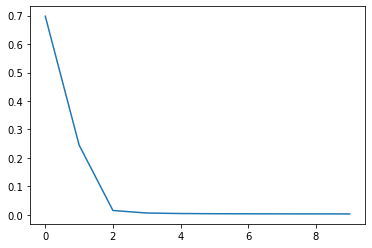

In [1069]:
 

plt.plot(test_losses)

In [1043]:
train['DNN_logits'] = logits.detach().cpu().numpy()

In [1044]:
train.shape

(4194, 20)

In [1070]:
# do this after getting logits for test set separately from the top
test['DNN_logits'] = logits.detach().cpu().numpy()

In [ ]:
# X = torch.rand(120, 1056, device=device)
# X

In [1071]:
test

,Unnamed: 0,loan_word,original_word,loan_word_epitran,original_word_epitran,loan_english,original_english,label,Fast Levenshtein,Dolgo Prime Distance,Feature Edit Distance,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen,label_bin,mbert_cos_similarity,xlm_cos_similarity,features_loan,features_orig,DNN_logits
0,812,क़र्ज़,چاروا,qərzə,t͡ʃɒrvɒ,debt,Charwa,hard_negative,0.875,0.125000,0.065104,0.072917,0.671875,0.875,0,0.488776,0.607569,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, -1,...","[-1, -1, 1, -1, 1, -1, -1, 0, -1, -1, -1, -1, ...",-9.210550
1,5527,प्रमोद,لذت بسیار,prəmod,lzt bsjɒr,Pramod,So much fun,synonym,1.000,0.777778,0.317130,0.365741,4.222222,1.000,0,0.384518,0.475078,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, 1, ...","[-1, 1, 1, 1, -1, 1, -1, 0, 1, -1, -1, 1, 1, -...",-11.989496
2,1246,अधीनस्थ,کمک,ad̤iːnstʰə,kmk,subordinate,Help,synonym,1.000,0.700000,0.420833,0.466667,3.512500,1.000,0,0.365239,0.594256,"[1, 1, -1, 1, -1, -1, -1, 0, 1, -1, -1, 0, -1,...","[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, -1,...",-15.287443
3,137,ओहदा,آرزو,oɦdaː,ɒrzv,position,Wish,random,1.000,0.200000,0.116667,0.150000,2.325000,1.000,0,0.440511,0.695991,"[1, 1, -1, 1, -1, -1, -1, 0, 1, -1, -1, 0, -1,...","[1, 1, -1, 1, -1, -1, -1, 0, 1, -1, -1, 0, -1,...",-7.222701
4,746,ढुलमुल,اسرار امیز,ɖ̤ulmul,ɒsrɒr ɒmjz,wavering,Mysterious,synonym,0.900,0.500000,0.333333,0.383333,3.312500,0.900,0,0.359298,0.718769,"[-1, -1, 1, -1, -1, -1, -1, 0, 1, 1, -1, -1, 1...","[1, 1, -1, 1, -1, -1, -1, 0, 1, -1, -1, 0, -1,...",-20.950424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,490,तजुर्बा,بهائی,təd͡ʒurbaː,bhɒيʔj,experience,Baha'i,random,1.000,0.500000,0.268750,0.304167,3.112500,1.000,0,0.368733,0.732720,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, 1, ...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, -...",-9.158766
462,1118,वरना,ورنه,vərnaː,vrnh,Otherwise,ورنه,loan,0.500,0.333333,0.190972,0.215278,2.145833,0.500,1,0.616410,0.478068,"[-1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, 1, -1...","[-1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, 1, -1...",8.675792
463,811,लवेबल,دوست داشتنی,ləvebəl,dvst dɒʃtnj,lovable,Lovely,synonym,1.000,0.727273,0.359848,0.401515,4.261364,1.000,0,0.411980,0.567750,"[-1, 1, 1, 1, -1, 1, -1, 0, 1, -1, -1, 1, 1, -...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...",-24.917213
464,1661,तेज़ी,فحش دادن,teziː,fhʃ dɒdn,swiftness,Swearing,synonym,1.000,0.500000,0.411458,0.453125,4.000000,1.000,0,0.402701,0.740800,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, 1, ...","[-1, -1, 1, 1, -1, -1, -1, 1, -1, -1, -1, 1, -...",-17.452015


# Pad features to max length with zeros where max length is extended to closest perfect square to the original max length of IPA characters

In [1072]:
X_train.shape[1], X_test.shape[1]  # these are original max lengths, so pad them on the right with torch zeros until closest perfect square so that CNNs can work 


(1032, 864)

In [1073]:
X_train_CNN = F.pad(X_train,pad =(0, 1089-X_train.shape[1]), value=0)
Y_train_CNN = Y_train

X_test_CNN = F.pad(X_test,pad =(0, 900-X_test.shape[1]), value=0)
Y_test_CNN = Y_test

In [1075]:
X_train_CNN.shape, Y_train_CNN.shape, X_test_CNN.shape, Y_test_CNN.shape

(torch.Size([4194, 1089]),
 torch.Size([4194, 1]),
 torch.Size([466, 900]),
 torch.Size([466, 1]))

In [1076]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 2) # input is 1 image, 32 output channels, 2X2 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 2) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128,2)
        

        #x = torch.randn(23,23).view(-1,1,23,23)
        x = torch.randn(33,33).view(-1,1,33,33) #33 because its the square root of 1089
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 1) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.tanh(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.tanh(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.tanh(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.tanh(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.sigmoid(x), x, #comment it out to get the logits in the return statement 
        #return x
                         


net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=1152, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)


/s/chopin/d/proj/ramfis-aida/venv/lib64/python3.6/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [1077]:
net

Net(
  (conv1): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=1152, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)

In [1078]:
#X_train = torch.tensor(X_train).view(-1,23,23).to(device)
X_train_CNN = torch.tensor(X_train_CNN).view(-1,33,33).to(device)
#X_train = torch.tensor(X_train).to(device)
#Y_train = torch.tensor(Y_train).to(device)
Y_train_CNN = torch.tensor(Y_train_CNN).to(device)
#X_test = torch.tensor(X_test).view(-1,23,23).to(device)

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [1079]:
# X_train = torch.tensor(X_train)
# Y_train = torch.tensor(Y_train)
# X_test = torch.tensor(X_test)
# Y_test = torch.tensor(Y_test)

In [904]:
# X_train_CNN = F.pad(X_train,pad =(0, 1089-X_train.shape[1]), value=0)
# Y_train_CNN = Y_train

# X_test_CNN = F.pad(X_test,pad =(0, 900-X_test.shape[1]), value=0)
# Y_test_CNN = Y_test

In [ ]:
# t4d = torch.ones(3, 3)
# p1d = (0, 1)

In [ ]:
# t4d = F.pad(t4d,pad =(0, 10-t4d.shape[1]), value=0)

In [ ]:
# t4d 

In [1080]:
X_train_CNN.shape, Y_train_CNN.shape, X_test_CNN.shape, Y_test_CNN.shape


(torch.Size([4194, 33, 33]),
 torch.Size([4194, 1]),
 torch.Size([466, 900]),
 torch.Size([466, 1]))

In [1081]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
#loss_function = nn.MSELoss()
loss_function = nn.BCELoss().to(device)

In [1082]:
from tqdm import tqdm

In [1083]:
loss_cnn_train = []
EPOCHS = 1000
BATCH_SIZE = 120
cnn_logits_lst = []
 
for epoch in range(EPOCHS):
    #for i in tqdm(range(0, len(X_train_CNN), BATCH_SIZE)):
    batch_X = X_train_CNN.view(-1, 1, 33,33)
    batch_y = Y_train_CNN


    net.zero_grad()
    outputs = net(batch_X.float())[0]
    cnn_logits = net(batch_X.float())[1]
    #cnn_logits_lst.extend(cnn_logits)
    #print(outputs)
    loss = loss_function(outputs,  batch_y.float().reshape((-1,1)))

    loss.backward()
    optimizer.step()
    loss_cnn_train.append(loss)
    if EPOCHS % 100 == 0:
        print(f"Epoch: {epoch}. Loss: {loss}")

/s/chopin/d/proj/ramfis-aida/venv/lib64/python3.6/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0. Loss: 0.7009398341178894
Epoch: 1. Loss: 0.6385523676872253
Epoch: 2. Loss: 0.6022046804428101
Epoch: 3. Loss: 0.6147534251213074
Epoch: 4. Loss: 0.6018617153167725
Epoch: 5. Loss: 0.5835819244384766
Epoch: 6. Loss: 0.5941641926765442
Epoch: 7. Loss: 0.5903205871582031
Epoch: 8. Loss: 0.5762678384780884
Epoch: 9. Loss: 0.5780029892921448
Epoch: 10. Loss: 0.5842543840408325
Epoch: 11. Loss: 0.5758993029594421
Epoch: 12. Loss: 0.5709930062294006
Epoch: 13. Loss: 0.5770629644393921
Epoch: 14. Loss: 0.577378511428833
Epoch: 15. Loss: 0.5711982846260071
Epoch: 16. Loss: 0.5716713070869446
Epoch: 17. Loss: 0.5757595896720886
Epoch: 18. Loss: 0.5729579329490662
Epoch: 19. Loss: 0.5694700479507446
Epoch: 20. Loss: 0.5713174939155579
Epoch: 21. Loss: 0.5725302696228027
Epoch: 22. Loss: 0.5698596239089966
Epoch: 23. Loss: 0.5682770609855652
Epoch: 24. Loss: 0.5697313547134399
Epoch: 25. Loss: 0.5701640248298645
Epoch: 26. Loss: 0.5683649778366089
Epoch: 27. Loss: 0.5675744414329529
Epo

Epoch: 228. Loss: 0.12489423155784607
Epoch: 229. Loss: 0.117103211581707
Epoch: 230. Loss: 0.11482753604650497
Epoch: 231. Loss: 0.11459778994321823
Epoch: 232. Loss: 0.1143447682261467
Epoch: 233. Loss: 0.1144733726978302
Epoch: 234. Loss: 0.11110281199216843
Epoch: 235. Loss: 0.10820706188678741
Epoch: 236. Loss: 0.10286073386669159
Epoch: 237. Loss: 0.09829135984182358
Epoch: 238. Loss: 0.0944618433713913
Epoch: 239. Loss: 0.09122738987207413
Epoch: 240. Loss: 0.0895959734916687
Epoch: 241. Loss: 0.08811209350824356
Epoch: 242. Loss: 0.08797844499349594
Epoch: 243. Loss: 0.08901543915271759
Epoch: 244. Loss: 0.09330421686172485
Epoch: 245. Loss: 0.10340698808431625
Epoch: 246. Loss: 0.12280011922121048
Epoch: 247. Loss: 0.1472439169883728
Epoch: 248. Loss: 0.1557733714580536
Epoch: 249. Loss: 0.1088499128818512
Epoch: 250. Loss: 0.07551449537277222
Epoch: 251. Loss: 0.1008945181965828
Epoch: 252. Loss: 0.10211849957704544
Epoch: 253. Loss: 0.07745905965566635
Epoch: 254. Loss: 0.07

Epoch: 444. Loss: 0.005694434512406588
Epoch: 445. Loss: 0.005664716009050608
Epoch: 446. Loss: 0.005635578650981188
Epoch: 447. Loss: 0.00560604827478528
Epoch: 448. Loss: 0.005577745847404003
Epoch: 449. Loss: 0.005548801738768816
Epoch: 450. Loss: 0.005521005485206842
Epoch: 451. Loss: 0.005493107717484236
Epoch: 452. Loss: 0.005465690512210131
Epoch: 453. Loss: 0.00543940020725131
Epoch: 454. Loss: 0.005412394180893898
Epoch: 455. Loss: 0.005386040546000004
Epoch: 456. Loss: 0.00536027317866683
Epoch: 457. Loss: 0.00533439964056015
Epoch: 458. Loss: 0.0053087081760168076
Epoch: 459. Loss: 0.005284029990434647
Epoch: 460. Loss: 0.005258786026388407
Epoch: 461. Loss: 0.005234213080257177
Epoch: 462. Loss: 0.0052101644687354565
Epoch: 463. Loss: 0.005185751244425774
Epoch: 464. Loss: 0.00516217527911067
Epoch: 465. Loss: 0.005138570908457041
Epoch: 466. Loss: 0.005115796346217394
Epoch: 467. Loss: 0.005092400126159191
Epoch: 468. Loss: 0.005069897044450045
Epoch: 469. Loss: 0.00504758

Epoch: 654. Loss: 0.003095675492659211
Epoch: 655. Loss: 0.00309099187143147
Epoch: 656. Loss: 0.0030862255953252316
Epoch: 657. Loss: 0.0030816735234111547
Epoch: 658. Loss: 0.0030769656877964735
Epoch: 659. Loss: 0.0030724876560270786
Epoch: 660. Loss: 0.003067800309509039
Epoch: 661. Loss: 0.0030633171554654837
Epoch: 662. Loss: 0.0030589255038648844
Epoch: 663. Loss: 0.003054528497159481
Epoch: 664. Loss: 0.003050039289519191
Epoch: 665. Loss: 0.003045563120394945
Epoch: 666. Loss: 0.003041235962882638
Epoch: 667. Loss: 0.003036926733329892
Epoch: 668. Loss: 0.0030325488187372684
Epoch: 669. Loss: 0.003028411651030183
Epoch: 670. Loss: 0.0030238579493016005
Epoch: 671. Loss: 0.0030197016894817352
Epoch: 672. Loss: 0.00301562063395977
Epoch: 673. Loss: 0.0030113684479147196
Epoch: 674. Loss: 0.003007130231708288
Epoch: 675. Loss: 0.003002996789291501
Epoch: 676. Loss: 0.002998931799083948
Epoch: 677. Loss: 0.0029948714654892683
Epoch: 678. Loss: 0.0029906746931374073
Epoch: 679. Los

Epoch: 864. Loss: 0.0025163362734019756
Epoch: 865. Loss: 0.0025147292762994766
Epoch: 866. Loss: 0.0025131129659712315
Epoch: 867. Loss: 0.002511483384296298
Epoch: 868. Loss: 0.002509992802515626
Epoch: 869. Loss: 0.0025085255037993193
Epoch: 870. Loss: 0.0025068637914955616
Epoch: 871. Loss: 0.0025054444558918476
Epoch: 872. Loss: 0.0025039527099579573
Epoch: 873. Loss: 0.0025025333743542433
Epoch: 874. Loss: 0.002500935224816203
Epoch: 875. Loss: 0.002499425783753395
Epoch: 876. Loss: 0.0024978886358439922
Epoch: 877. Loss: 0.002496450673788786
Epoch: 878. Loss: 0.002495007123798132
Epoch: 879. Loss: 0.0024934690445661545
Epoch: 880. Loss: 0.002492049243301153
Epoch: 881. Loss: 0.0024906389880925417
Epoch: 882. Loss: 0.0024891821667551994
Epoch: 883. Loss: 0.0024876180104911327
Epoch: 884. Loss: 0.0024862876161932945
Epoch: 885. Loss: 0.0024848610628396273
Epoch: 886. Loss: 0.00248348293825984
Epoch: 887. Loss: 0.00248200842179358
Epoch: 888. Loss: 0.002480624243617058
Epoch: 889. 

4194

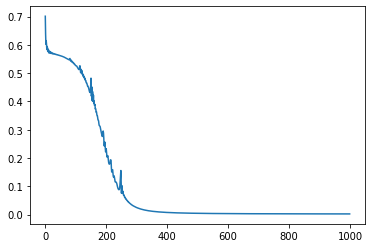

In [1084]:
plt.plot(loss_cnn_train)
len(cnn_logits)

In [1085]:
train['CNN_logits'] =cnn_logits.detach().cpu().numpy()

In [1086]:
 #train = train.loc[train["original_word"]!='Refulgent'].shape  #very dangerous line here!

In [1087]:
train

,Unnamed: 0,loan_word,original_word,loan_word_epitran,original_word_epitran,loan_english,original_english,label,Fast Levenshtein,Dolgo Prime Distance,...,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen,label_bin,mbert_cos_similarity,xlm_cos_similarity,features_loan,features_orig,DNN_logits,CNN_logits
0,136,ओ,بیتاب,o,bjtɒb,O,Impatient,random,1.000000,0.800000,...,0.808333,5.900000,1.000000,0,0.420495,0.697084,"[1, 1, -1, 1, -1, -1, -1, 0, 1, -1, -1, 0, -1,...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, -...",-16.218758,-6.709172
1,624,दुख़्तर,دختر,duxtər,dxtr,pain,Girl,loan,0.333333,0.333333,...,0.333333,2.416667,0.333333,1,0.452070,0.516028,"[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...",8.018238,7.578733
2,1079,रूह,روح,ruːɦ,rvh,spirit,Soul,loan,0.750000,0.250000,...,0.114583,2.187500,0.750000,1,0.506079,0.719540,"[-1, 1, 1, 1, 0, -1, -1, 0, 1, -1, -1, 1, 1, -...","[-1, 1, 1, 1, 0, -1, -1, 0, 1, -1, -1, 1, 1, -...",8.149307,13.127642
3,976,मुअल्लिमा,معلمه,muallimaː,mʔlmh,Muallima,Teacher,loan,0.666667,0.444444,...,0.398148,3.527778,0.666667,1,0.436408,0.725925,"[-1, 1, 1, -1, -1, -1, 1, 0, 1, -1, -1, 1, -1,...","[-1, 1, 1, -1, -1, -1, 1, 0, 1, -1, -1, 1, -1,...",7.360963,11.419708
4,4646,मलिका,ماجراجو,məlikaː,mɒd͡ʒrɒd͡ʒv,malika,Adventurer,hard_negative,0.916667,0.166667,...,0.177083,1.864583,0.916667,0,0.697087,0.756841,"[-1, 1, 1, -1, -1, -1, 1, 0, 1, -1, -1, 1, -1,...","[-1, 1, 1, -1, -1, -1, 1, 0, 1, -1, -1, 1, -1,...",-16.619883,-9.829449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4191,260,ख़ालिक़,جاری,xaːliq,d͡ʒɒrj,pure,Current,random,1.000000,0.333333,...,0.291667,2.666667,1.000000,0,0.333789,0.746394,"[-1, -1, 1, 1, -1, -1, -1, 0, -1, -1, -1, -1, ...","[-1, -1, 1, -1, 1, -1, -1, 0, 1, -1, -1, -1, 1...",-7.594423,-20.254333
4192,2208,पकड़ना,فهم,pəkɽənaː,fhm,Catch,Understanding,synonym,1.000000,0.625000,...,0.546875,4.140625,1.000000,0,0.493462,0.387989,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, 1, ...","[-1, -1, 1, 1, -1, -1, -1, 1, -1, -1, -1, 1, -...",-7.256489,-12.875332
4193,4169,प्रशंसा,ستایش,prəʃənsaː,stɒjʃ,Praise,Praise,synonym,1.000000,0.555556,...,0.421296,3.638889,1.000000,0,0.537812,0.747160,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, 1, ...","[-1, -1, 1, 1, -1, -1, -1, 0, -1, -1, -1, 1, 1...",-20.811543,-18.016346
4194,1263,सिलसिला,سلسله,silsilaː,slslh,continuation,Series,loan,0.500000,0.375000,...,0.286458,2.515625,0.500000,1,0.469336,0.535746,"[-1, -1, 1, 1, -1, -1, -1, 0, -1, -1, -1, 1, 1...","[-1, -1, 1, 1, -1, -1, -1, 0, -1, -1, -1, 1, 1...",9.651114,10.320404


In [1088]:
train.to_csv('train_withlogits_prod.csv')

In [65]:
# test.to_csv('test_withlogits.csv')

In [42]:
#train = pd.read_csv('train_withlogits.csv')
# test = pd.read_csv('test_withlogits.csv')

In [40]:
train['CNN_logits'] =cnn_logits.detach().cpu().numpy()

In [1089]:
train.shape

(4194, 21)

# Getting logits from CNN test set

In [1090]:
class Net_test(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 2) # input is 1 image, 32 output channels, 2X2 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 2) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128,2)
        

        #x = torch.randn(23,23).view(-1,1,23,23)
        x = torch.randn(30,30).view(-1,1,30,30)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 1) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.tanh(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.tanh(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.tanh(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.tanh(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.sigmoid(x), x, #comment it out to get the logits in the return statement 
        #return x
                         


net = Net_test().to(device)
print(net)

Net_test(
  (conv1): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)


/s/chopin/d/proj/ramfis-aida/venv/lib64/python3.6/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [1091]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
#loss_function = nn.MSELoss()
loss_function = nn.BCELoss().to(device)

In [1092]:
loss_cnn_test = []
EPOCHS = 1000
BATCH_SIZE = 120
cnn_logits_lst_test = []
 
for epoch in range(EPOCHS):
    #for i in tqdm(range(0, len(X_train_CNN), BATCH_SIZE)):
    batch_X = X_test_CNN.view(-1, 1, 30,30)
    batch_y = Y_test_CNN


    net.zero_grad()
    outputs = net(batch_X.float())[0]
    cnn_logits_test = net(batch_X.float())[1]
    #cnn_logits_lst.extend(cnn_logits)
    #print(outputs)
    loss = loss_function(outputs,  batch_y.float().reshape((-1,1)))

    loss.backward()
    optimizer.step()
    loss_cnn_test.append(loss)
    if EPOCHS % 100 == 0:
        print(f"Epoch: {epoch}. Loss: {loss}")

/s/chopin/d/proj/ramfis-aida/venv/lib64/python3.6/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0. Loss: 0.6879889369010925
Epoch: 1. Loss: 0.6125616431236267
Epoch: 2. Loss: 0.6369106769561768
Epoch: 3. Loss: 0.6110633611679077
Epoch: 4. Loss: 0.6238124370574951
Epoch: 5. Loss: 0.6186586022377014
Epoch: 6. Loss: 0.6053056716918945
Epoch: 7. Loss: 0.6099947690963745
Epoch: 8. Loss: 0.6117966175079346
Epoch: 9. Loss: 0.6031708717346191
Epoch: 10. Loss: 0.5995726585388184
Epoch: 11. Loss: 0.603376567363739
Epoch: 12. Loss: 0.6022711992263794
Epoch: 13. Loss: 0.5960303544998169
Epoch: 14. Loss: 0.5943571925163269
Epoch: 15. Loss: 0.5968614816665649
Epoch: 16. Loss: 0.5945163369178772
Epoch: 17. Loss: 0.5900189876556396
Epoch: 18. Loss: 0.5904158353805542
Epoch: 19. Loss: 0.5912238359451294
Epoch: 20. Loss: 0.5874618291854858
Epoch: 21. Loss: 0.5851168632507324
Epoch: 22. Loss: 0.5859919786453247
Epoch: 23. Loss: 0.5836492776870728
Epoch: 24. Loss: 0.5802352428436279
Epoch: 25. Loss: 0.5801452994346619
Epoch: 26. Loss: 0.5783249139785767
Epoch: 27. Loss: 0.5747095942497253
Epo

Epoch: 261. Loss: 0.003735827747732401
Epoch: 262. Loss: 0.0037291485350579023
Epoch: 263. Loss: 0.003722871420904994
Epoch: 264. Loss: 0.0037162327207624912
Epoch: 265. Loss: 0.0037098033353686333
Epoch: 266. Loss: 0.0037036980502307415
Epoch: 267. Loss: 0.003697441192343831
Epoch: 268. Loss: 0.003691348945721984
Epoch: 269. Loss: 0.0036852224729955196
Epoch: 270. Loss: 0.003679449437186122
Epoch: 271. Loss: 0.00367349898442626
Epoch: 272. Loss: 0.003667603712528944
Epoch: 273. Loss: 0.00366196408867836
Epoch: 274. Loss: 0.0036563824396580458
Epoch: 275. Loss: 0.0036507737822830677
Epoch: 276. Loss: 0.0036452694330364466
Epoch: 277. Loss: 0.0036398505326360464
Epoch: 278. Loss: 0.003634657012298703
Epoch: 279. Loss: 0.0036293251905590296
Epoch: 280. Loss: 0.003624028991907835
Epoch: 281. Loss: 0.0036188983358442783
Epoch: 282. Loss: 0.003613774897530675
Epoch: 283. Loss: 0.003608692204579711
Epoch: 284. Loss: 0.003603774355724454
Epoch: 285. Loss: 0.0035988634917885065
Epoch: 286. Los

Epoch: 472. Loss: 0.0032102365512400866
Epoch: 473. Loss: 0.0032160275150090456
Epoch: 474. Loss: 0.0032231782097369432
Epoch: 475. Loss: 0.003233846742659807
Epoch: 476. Loss: 0.003246038220822811
Epoch: 477. Loss: 0.003257819451391697
Epoch: 478. Loss: 0.0032691792584955692
Epoch: 479. Loss: 0.0032801178749650717
Epoch: 480. Loss: 0.0032866313122212887
Epoch: 481. Loss: 0.0032860725186765194
Epoch: 482. Loss: 0.0032964914571493864
Epoch: 483. Loss: 0.003309728344902396
Epoch: 484. Loss: 0.003323278622701764
Epoch: 485. Loss: 0.0033365769777446985
Epoch: 486. Loss: 0.003342409385368228
Epoch: 487. Loss: 0.003336160909384489
Epoch: 488. Loss: 0.0033204418141394854
Epoch: 489. Loss: 0.0033002591226249933
Epoch: 490. Loss: 0.003278893418610096
Epoch: 491. Loss: 0.003258424811065197
Epoch: 492. Loss: 0.0032404905650764704
Epoch: 493. Loss: 0.0032262129243463278
Epoch: 494. Loss: 0.0032156112138181925
Epoch: 495. Loss: 0.003208945272490382
Epoch: 496. Loss: 0.0032064171973615885
Epoch: 497

Epoch: 683. Loss: 0.0033903131261467934
Epoch: 684. Loss: 0.0033355415798723698
Epoch: 685. Loss: 0.0032855942845344543
Epoch: 686. Loss: 0.0032496112398803234
Epoch: 687. Loss: 0.0032318660523742437
Epoch: 688. Loss: 0.003230172907933593
Epoch: 689. Loss: 0.003245389787480235
Epoch: 690. Loss: 0.003273617709055543
Epoch: 691. Loss: 0.003308319952338934
Epoch: 692. Loss: 0.003341226140037179
Epoch: 693. Loss: 0.003363740397617221
Epoch: 694. Loss: 0.003371767234057188
Epoch: 695. Loss: 0.0033611732069402933
Epoch: 696. Loss: 0.0033337888307869434
Epoch: 697. Loss: 0.003301451215520501
Epoch: 698. Loss: 0.0032749546226114035
Epoch: 699. Loss: 0.0032565584406256676
Epoch: 700. Loss: 0.0032473281025886536
Epoch: 701. Loss: 0.0032459229696542025
Epoch: 702. Loss: 0.0032536936923861504
Epoch: 703. Loss: 0.0032675459515303373
Epoch: 704. Loss: 0.003286530962213874
Epoch: 705. Loss: 0.003307074774056673
Epoch: 706. Loss: 0.0033249743282794952
Epoch: 707. Loss: 0.003336158348247409
Epoch: 708.

Epoch: 893. Loss: 0.0032814175356179476
Epoch: 894. Loss: 0.0032888296991586685
Epoch: 895. Loss: 0.0032902287784963846
Epoch: 896. Loss: 0.003284320468083024
Epoch: 897. Loss: 0.00327483844012022
Epoch: 898. Loss: 0.0032659999560564756
Epoch: 899. Loss: 0.0032598956022411585
Epoch: 900. Loss: 0.0032563398126512766
Epoch: 901. Loss: 0.003254230134189129
Epoch: 902. Loss: 0.0032525742426514626
Epoch: 903. Loss: 0.0032532671466469765
Epoch: 904. Loss: 0.0032557642553001642
Epoch: 905. Loss: 0.0032605717424303293
Epoch: 906. Loss: 0.003267495660111308
Epoch: 907. Loss: 0.003273898968473077
Epoch: 908. Loss: 0.003277129726484418
Epoch: 909. Loss: 0.003273302223533392
Epoch: 910. Loss: 0.003265602281317115
Epoch: 911. Loss: 0.0032571901101619005
Epoch: 912. Loss: 0.0032491248566657305
Epoch: 913. Loss: 0.003243230516090989
Epoch: 914. Loss: 0.003237784141674638
Epoch: 915. Loss: 0.00323508121073246
Epoch: 916. Loss: 0.00323523860424757
Epoch: 917. Loss: 0.0032397888135164976
Epoch: 918. Los

466

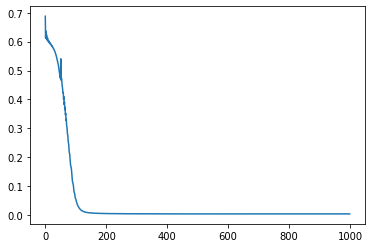

In [1093]:
plt.plot(loss_cnn_test)
len(cnn_logits_test)

In [1094]:
test['CNN_logits'] =cnn_logits_test.detach().cpu().numpy()

In [1096]:
test.to_csv('test_withlogits_prod.csv')

# Classifiers on final train/test set: logistic reg, SVM(rbf), Random Forest etc

In [1097]:
import sklearn as sk
from sklearn.linear_model import LogisticRegression

In [1098]:
test = pd.read_csv('test_withlogits_prod.csv')

In [1099]:
train = pd.read_csv('train_withlogits_prod.csv')

In [1118]:
train.shape, test.shape
train

,Unnamed: 0,Unnamed: 0.1,loan_word,original_word,loan_word_epitran,original_word_epitran,loan_english,original_english,label,Fast Levenshtein,...,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen,label_bin,mbert_cos_similarity,xlm_cos_similarity,features_loan,features_orig,DNN_logits,CNN_logits
0,0,136,ओ,بیتاب,o,bjtɒb,O,Impatient,random,1.000000,...,0.808333,5.900000,1.000000,0,0.420495,0.697084,"[1, 1, -1, 1, -1, -1, -1, 0, 1, -1, -1, 0, -1,...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, -...",-16.218758,-6.709172
1,1,624,दुख़्तर,دختر,duxtər,dxtr,pain,Girl,loan,0.333333,...,0.333333,2.416667,0.333333,1,0.452070,0.516028,"[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...",8.018238,7.578733
2,2,1079,रूह,روح,ruːɦ,rvh,spirit,Soul,loan,0.750000,...,0.114583,2.187500,0.750000,1,0.506079,0.719540,"[-1, 1, 1, 1, 0, -1, -1, 0, 1, -1, -1, 1, 1, -...","[-1, 1, 1, 1, 0, -1, -1, 0, 1, -1, -1, 1, 1, -...",8.149307,13.127642
3,3,976,मुअल्लिमा,معلمه,muallimaː,mʔlmh,Muallima,Teacher,loan,0.666667,...,0.398148,3.527778,0.666667,1,0.436408,0.725925,"[-1, 1, 1, -1, -1, -1, 1, 0, 1, -1, -1, 1, -1,...","[-1, 1, 1, -1, -1, -1, 1, 0, 1, -1, -1, 1, -1,...",7.360963,11.419708
4,4,4646,मलिका,ماجراجو,məlikaː,mɒd͡ʒrɒd͡ʒv,malika,Adventurer,hard_negative,0.916667,...,0.177083,1.864583,0.916667,0,0.697087,0.756841,"[-1, 1, 1, -1, -1, -1, 1, 0, 1, -1, -1, 1, -1,...","[-1, 1, 1, -1, -1, -1, 1, 0, 1, -1, -1, 1, -1,...",-16.619883,-9.829449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4189,4191,260,ख़ालिक़,جاری,xaːliq,d͡ʒɒrj,pure,Current,random,1.000000,...,0.291667,2.666667,1.000000,0,0.333789,0.746394,"[-1, -1, 1, 1, -1, -1, -1, 0, -1, -1, -1, -1, ...","[-1, -1, 1, -1, 1, -1, -1, 0, 1, -1, -1, -1, 1...",-7.594423,-20.254333
4190,4192,2208,पकड़ना,فهم,pəkɽənaː,fhm,Catch,Understanding,synonym,1.000000,...,0.546875,4.140625,1.000000,0,0.493462,0.387989,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, 1, ...","[-1, -1, 1, 1, -1, -1, -1, 1, -1, -1, -1, 1, -...",-7.256489,-12.875332
4191,4193,4169,प्रशंसा,ستایش,prəʃənsaː,stɒjʃ,Praise,Praise,synonym,1.000000,...,0.421296,3.638889,1.000000,0,0.537812,0.747160,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, 1, ...","[-1, -1, 1, 1, -1, -1, -1, 0, -1, -1, -1, 1, 1...",-20.811543,-18.016346
4192,4194,1263,सिलसिला,سلسله,silsilaː,slslh,continuation,Series,loan,0.500000,...,0.286458,2.515625,0.500000,1,0.469336,0.535746,"[-1, -1, 1, 1, -1, -1, -1, 0, -1, -1, -1, 1, 1...","[-1, -1, 1, 1, -1, -1, -1, 0, -1, -1, -1, 1, 1...",9.651113,10.320404


# Try both a miniature train-like test set and a class-balanced test set

In [1110]:
features =  ['Fast Levenshtein', 'Dolgo Prime Distance',
       'Feature Edit Distance', 'Hamming Feature Distance',
       'Weighted Feature Distance', 'Fast Levenshtein Distance Div Maxlen','mbert_cos_similarity', 'xlm_cos_similarity',
             'CNN_logits', 'DNN_logits'
        ]

# features =  ['Fast Levenshtein', 'Dolgo Prime Distance',
#        'Feature Edit Distance', 'Hamming Feature Distance',
#        'Weighted Feature Distance', 'Fast Levenshtein Distance Div Maxlen', 
#         ]

labels = ['label_bin']

In [1111]:
idx = test['label_bin']==0
testneg = test.loc[idx][:140] 
testpos = test.loc[test['label_bin']==1]

In [1112]:
testneg.shape, testpos.shape
test_balanced = pd.concat([testpos, testneg])
test_balanced.shape

(283, 22)

In [1113]:
x_train = train[features].values
y_train = train[labels].values.ravel()
x_test = test[features].values
y_test = test[labels].values.ravel()

# x_test = test_balanced[features].values
# y_test = test_balanced[labels].values.ravel()


In [1117]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4194, 10), (4194,), (466, 10), (466,))

In [1119]:
y_train

array([0, 1, 1, ..., 0, 1, 0])

In [1116]:
x_train

array([[  1.        ,   0.8       ,   0.72916667, ...,   0.69708389,
         -6.7091722 , -16.218758  ],
       [  0.33333333,   0.33333333,   0.29861111, ...,   0.51602769,
          7.5787334 ,   8.018238  ],
       [  0.75      ,   0.25      ,   0.09895833, ...,   0.71954006,
         13.127642  ,   8.149307  ],
       ...,
       [  1.        ,   0.55555556,   0.375     , ...,   0.7471602 ,
        -18.016346  , -20.811543  ],
       [  0.5       ,   0.375     ,   0.25520833, ...,   0.53574562,
         10.320404  ,   9.6511135 ],
       [  1.        ,   0.75      ,   0.44618056, ...,   0.11130369,
         -9.297581  , -28.92412   ]])

# Train a binary logistic regression classifier and testing with logits plus edit dist and cosine sims  as features: 10 features total: 

In [1125]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [1127]:
#try after standardizing the data including the logits. 
stand= StandardScaler()
fit = stand.fit(x_train)
x_train = fit.transform(x_train)

x_test = fit.transform(x_test)

In [1128]:
LR = LogisticRegression(random_state=1, solver='lbfgs', multi_class='ovr', max_iter=500 ).fit(x_train, y_train)

In [1129]:
y_pred = LR.predict(x_test)

In [1130]:
print("f1-score : ", f1_score(y_test, y_pred ))
print("precision : ",precision_score(y_test, y_pred))
print("recall : ",recall_score(y_test, y_pred )) 
print("accuracy : ",accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

f1-score :  0.9965156794425087
precision :  0.9930555555555556
recall :  1.0
accuracy :  0.9978540772532188
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       323
           1       0.99      1.00      1.00       143

    accuracy                           1.00       466
   macro avg       1.00      1.00      1.00       466
weighted avg       1.00      1.00      1.00       466

[[322   1]
 [  0 143]]


In [1131]:
unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])

In [1132]:
tp = np.array(np.where(unq == 3)).tolist()[0]
fp = np.array(np.where(unq == 1)).tolist()[0]
tn = np.array(np.where(unq == 0)).tolist()[0]
fn = np.array(np.where(unq == 2)).tolist()[0]

# for train-like test set, recall is very high with a slightly lower precision, 8 FP and no FN

In [1133]:
test.iloc[fp,:]

,Unnamed: 0,Unnamed: 0.1,loan_word,original_word,loan_word_epitran,original_word_epitran,loan_english,original_english,label,Fast Levenshtein,...,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen,label_bin,mbert_cos_similarity,xlm_cos_similarity,features_loan,features_orig,DNN_logits,CNN_logits
305,305,1443,ख़्वाजा,خواجه,xvaːd͡ʒaː,xvɒd͡ʒh,Khwaja,خواجه,hard_negative,0.444444,...,0.046296,0.791667,0.444444,0,0.513219,0.78262,"[-1, -1, 1, 1, -1, -1, -1, 0, -1, -1, -1, -1, ...","[-1, -1, 1, 1, -1, -1, -1, 0, -1, -1, -1, -1, ...",-0.000329,-0.64623


In [587]:
test.iloc[fn,:]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,loan_word,original_word,loan_word_epitran,original_word_epitran,Fast Levenshtein,Dolgo Prime Distance,Feature Edit Distance,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen,label,mbert_cos_similarity,xlm_cos_similarity,features_loan,features_orig,DNN_logits,CNN_logits


In [550]:
#try after standardizing the data including the logits. 
stand= StandardScaler()
fit = stand.fit(x_train)
x_train = fit.transform(x_train)

x_test = fit.transform(x_test)

In [567]:

LR = LogisticRegression(random_state=1, solver='lbfgs', multi_class='ovr', max_iter=500 ).fit(x_train, y_train)

In [568]:
y_pred = LR.predict(x_test)

In [569]:
print("f1-score : ", f1_score(y_test, y_pred ))
print("precision : ",precision_score(y_test, y_pred))
print("recall : ",recall_score(y_test, y_pred )) 
print("accuracy : ",accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

f1-score :  0.9225092250922509
precision :  0.9765625
recall :  0.8741258741258742
accuracy :  0.9257950530035336
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       140
           1       0.98      0.87      0.92       143

    accuracy                           0.93       283
   macro avg       0.93      0.93      0.93       283
weighted avg       0.93      0.93      0.93       283

[[137   3]
 [ 18 125]]


In [555]:
precision, recall, fscore, support = score(y_pred, y_test, pos_label=1)

In [556]:
print('fscore: {}'.format(fscore))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))

print('support: {}'.format(support))

fscore: [0.92881356 0.92250923]
precision: [0.97857143 0.87412587]
recall: [0.88387097 0.9765625 ]
support: [155 128]


In [455]:
sum(y_train==0)

3198

In [560]:
unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])

In [561]:
tp = np.array(np.where(unq == 3)).tolist()[0]
fp = np.array(np.where(unq == 1)).tolist()[0]
tn = np.array(np.where(unq == 0)).tolist()[0]
fn = np.array(np.where(unq == 2)).tolist()[0]

In [564]:
test_balanced.iloc[fp,:]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,loan_word,original_word,loan_word_epitran,original_word_epitran,Fast Levenshtein,Dolgo Prime Distance,Feature Edit Distance,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen,label,mbert_cos_similarity,xlm_cos_similarity,features_loan,features_orig,DNN_logits,CNN_logits
78,78,78,11390,दुश्वार,دور,duʃvaːr,dvr,0.571429,0.428571,0.386905,0.428571,3.107143,0.571429,0,0.428112,0.321477,"[-1, -1, 1, 1, -1, -1, -1, 0, 1, -1, -1, 1, 1,...","[-1, -1, 1, 1, -1, -1, -1, 0, 1, -1, -1, 1, 1,...",-8.963047,-11.555681
94,94,94,8530,जामा,جگر,d͡ʒaːmaː,d͡ʒɡr,0.625000,0.375000,0.182292,0.213542,2.281250,0.625000,0,0.630003,0.612502,"[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, -...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, -...",-13.170180,-7.685933
182,182,182,9841,ज़र्रा,زار زار,zərraː,zɒr zɒr,0.714286,0.285714,0.172619,0.208333,1.857143,0.714286,0,0.462647,0.596593,"[1, 1, -1, 1, -1, -1, -1, 0, 1, -1, -1, 0, -1,...","[1, 1, -1, 1, -1, -1, -1, 0, 1, -1, -1, 0, -1,...",-7.707266,-11.462407


In [563]:
test_balanced.iloc[fn,:]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,loan_word,original_word,loan_word_epitran,original_word_epitran,Fast Levenshtein,Dolgo Prime Distance,Feature Edit Distance,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen,label,mbert_cos_similarity,xlm_cos_similarity,features_loan,features_orig,DNN_logits,CNN_logits
66,66,66,4,अंदरुनी,اندرونی,ndəruniː,ɒndrvnj,0.625000,0.500000,0.153646,0.182292,3.171875,0.625000,1,0.484583,0.788032,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, 1, ...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...",8.576007,8.895311
71,71,71,604,-दान,دانستن,-daːn,dɒnstn,0.833333,0.500000,0.479167,0.520833,3.875000,0.833333,1,0.293757,0.621542,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, 1, ...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...",6.620969,7.180840
76,76,76,601,दहेज़,جهیز,dəɦez,d͡ʒhjz,0.666667,0.500000,0.197917,0.222222,1.937500,0.666667,1,0.466845,0.620716,"[-1, -1, 1, 1, -1, -1, -1, 0, -1, -1, -1, 1, 1...","[-1, -1, 1, 1, -1, -1, -1, 0, 1, -1, -1, -1, -...",29.674936,10.942152
81,81,81,526,तश्तरी,تشت,təʃtəriː,tʃt,0.625000,0.500000,0.440104,0.500000,3.625000,0.625000,1,0.590817,0.547848,"[1, 1, -1, 1, -1, -1, -1, 0, 1, -1, -1, 0, -1,...","[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, 1, ...",14.743056,10.560655
92,92,92,1236,सही,صحیح,səɦiː,shjh,0.800000,0.400000,0.108333,0.125000,2.650000,0.800000,1,0.488294,0.608805,"[-1, -1, 1, 1, -1, -1, -1, 0, 1, -1, -1, 1, 1,...","[-1, -1, 1, 1, -1, -1, -1, 0, 1, -1, -1, 1, 1,...",8.049563,8.439472
107,107,107,272,ख़ुशनवीसी,خُوشنَوِیسی,xuʃnəviːsiː,xُvʃnowejsj,0.727273,0.363636,0.160985,0.181818,2.363636,0.727273,1,0.560712,0.560799,"[-1, -1, 1, 1, -1, -1, -1, 0, -1, -1, -1, -1, ...","[-1, -1, 1, 1, -1, -1, -1, 0, -1, -1, -1, -1, ...",7.862397,8.812596
112,112,112,727,पहल,پهلو,pəɦəl,پhlv,1.000000,0.800000,0.462500,0.516667,4.775000,1.000000,1,0.708759,0.752857,"[-1, -1, 1, 1, -1, -1, -1, 0, -1, -1, -1, 1, 1...","[-1, -1, 1, 1, -1, -1, -1, 0, -1, -1, -1, 1, 1...",8.313698,9.281388
136,136,136,76,आलू,آلو,aːluː,ɒlv,0.800000,0.200000,0.095833,0.108333,2.000000,0.800000,1,0.625537,0.419534,"[-1, 1, 1, -1, -1, -1, 1, 0, 1, -1, -1, 1, 1, ...","[-1, 1, 1, -1, -1, -1, 1, 0, 1, -1, -1, 1, 1, ...",8.036224,11.560460
167,167,167,781,फ़िरंगी,فرنگی,firəŋɡiː,frŋj,0.625000,0.500000,0.351562,0.395833,3.078125,0.625000,1,0.574454,0.696136,"[-1, 1, 1, -1, -1, -1, 1, 0, 1, -1, -1, 1, -1,...","[-1, 1, 1, -1, -1, -1, 1, 0, 1, -1, -1, 1, -1,...",7.528652,8.187250
220,220,220,725,पहरा,پهره,pəɦraː,پhrh,0.833333,0.500000,0.347222,0.388889,3.395833,0.833333,1,0.700302,0.729959,"[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...",6.872724,6.540695


# Train a binary logistic regression classifier and testing with   edit dist as features only

In [1134]:
features =  ['Fast Levenshtein', 'Dolgo Prime Distance',
       'Feature Edit Distance', 'Hamming Feature Distance',
       'Weighted Feature Distance', 'Fast Levenshtein Distance Div Maxlen', 
        ]

In [1135]:
x_train = train[features].values
y_train = train[labels].values.ravel()
x_test = test[features].values
y_test = test[labels].values.ravel()

In [1136]:
# stand= StandardScaler()
# fit = stand.fit(x_train)
# x_train = fit.transform(x_train)

# x_test = fit.transform(x_test)

In [1140]:
x_train.shape, y_train.shape, x_test.shape, y_train.shape
 

((4194, 6), (4194,), (466, 6), (4194,))

In [1141]:

LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr', max_iter=500 ).fit(x_train, y_train)

In [1142]:
y_pred = LR.predict(x_test)

In [1143]:
print("f1-score : ", f1_score(y_test, y_pred ))
print("precision : ",precision_score(y_test, y_pred))
print("recall : ",recall_score(y_test, y_pred )) 
print("accuracy : ",accuracy_score(y_test, y_pred))

f1-score :  0.9052631578947369
precision :  0.9084507042253521
recall :  0.9020979020979021
accuracy :  0.9420600858369099


In [1144]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       323
           1       0.91      0.90      0.91       143

    accuracy                           0.94       466
   macro avg       0.93      0.93      0.93       466
weighted avg       0.94      0.94      0.94       466



# Train a binary logistic regression classifier and testing with   edit dist and cosine sims as features

In [1145]:
features =  ['Fast Levenshtein', 'Dolgo Prime Distance',
       'Feature Edit Distance', 'Hamming Feature Distance',
       'Weighted Feature Distance', 'Fast Levenshtein Distance Div Maxlen','mbert_cos_similarity', 'xlm_cos_similarity',
             
        ]

In [1146]:
x_train = train[features].values
y_train = train[labels].values.ravel()
x_test = test[features].values
y_test = test[labels].values.ravel()

In [1147]:
stand= StandardScaler()
fit = stand.fit(x_train)
x_train = fit.transform(x_train)

x_test = fit.transform(x_test)

In [1148]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4194, 8), (4194,), (466, 8), (466,))

In [1149]:

LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr', max_iter=500 ).fit(x_train, y_train)

In [1150]:
y_pred = LR.predict(x_test)

In [1151]:
print("f1-score : ", f1_score(y_test, y_pred ))
print("precision : ",precision_score(y_test, y_pred))
print("recall : ",recall_score(y_test, y_pred )) 
print("accuracy : ",accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

f1-score :  0.9295774647887325
precision :  0.9361702127659575
recall :  0.9230769230769231
accuracy :  0.9570815450643777
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       323
           1       0.94      0.92      0.93       143

    accuracy                           0.96       466
   macro avg       0.95      0.95      0.95       466
weighted avg       0.96      0.96      0.96       466



# Try with SVM with various combinations of features

In [1152]:
from sklearn import svm


In [1153]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(x_train, y_train)

SVC(kernel='linear')

In [1154]:
y_pred = svclassifier.predict(x_test)

In [1155]:
print("f1-score : ", f1_score(y_test, y_pred ))
print("precision : ",precision_score(y_test, y_pred))
print("recall : ",recall_score(y_test, y_pred )) 
print("accuracy : ",accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

f1-score :  0.9305555555555555
precision :  0.9241379310344827
recall :  0.9370629370629371
accuracy :  0.9570815450643777
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       323
           1       0.92      0.94      0.93       143

    accuracy                           0.96       466
   macro avg       0.95      0.95      0.95       466
weighted avg       0.96      0.96      0.96       466



# with all 10 features 

In [1156]:
features =  ['Fast Levenshtein', 'Dolgo Prime Distance',
       'Feature Edit Distance', 'Hamming Feature Distance',
       'Weighted Feature Distance', 'Fast Levenshtein Distance Div Maxlen','mbert_cos_similarity', 'xlm_cos_similarity',
             'CNN_logits', 'DNN_logits'
        ]

In [1157]:
x_train = train[features].values
y_train = train[labels].values.ravel()
x_test = test[features].values
y_test = test[labels].values.ravel()

In [1159]:
stand= StandardScaler()
fit = stand.fit(x_train)
x_train = fit.transform(x_train)

x_test = fit.transform(x_test)

In [1160]:
svclassifier = SVC(kernel='rbf')
svclassifier.fit(x_train, y_train)

SVC()

In [1161]:
y_pred = svclassifier.predict(x_test)

In [1162]:
print("f1-score : ", f1_score(y_test, y_pred ))
print("precision : ",precision_score(y_test, y_pred))
print("recall : ",recall_score(y_test, y_pred )) 
print("accuracy : ",accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

f1-score :  0.9965156794425087
precision :  0.9930555555555556
recall :  1.0
accuracy :  0.9978540772532188
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       323
           1       0.99      1.00      1.00       143

    accuracy                           1.00       466
   macro avg       1.00      1.00      1.00       466
weighted avg       1.00      1.00      1.00       466



# with edit distances and cosine sim: 8 features

In [1163]:
features =  ['Fast Levenshtein', 'Dolgo Prime Distance',
       'Feature Edit Distance', 'Hamming Feature Distance',
       'Weighted Feature Distance', 'Fast Levenshtein Distance Div Maxlen','mbert_cos_similarity', 'xlm_cos_similarity',
             
        ]

In [1164]:
x_train = train[features].values
y_train = train[labels].values.ravel()
x_test = test[features].values
y_test = test[labels].values.ravel()

In [1165]:
# stand= StandardScaler()
# fit = stand.fit(x_train)
# x_train = fit.transform(x_train)

# x_test = fit.transform(x_test)

In [1166]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4194, 8), (4194,), (466, 8), (466,))

In [1167]:
svclassifier = SVC(kernel='rbf')
svclassifier.fit(x_train, y_train)

SVC()

In [1168]:
y_pred = svclassifier.predict(x_test)

In [1170]:
print("f1-score : ", f1_score(y_test, y_pred ))
print("precision : ",precision_score(y_test, y_pred))
print("recall : ",recall_score(y_test, y_pred )) 
print("accuracy : ",accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

f1-score :  0.9305555555555555
precision :  0.9241379310344827
recall :  0.9370629370629371
accuracy :  0.9570815450643777
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       323
           1       0.92      0.94      0.93       143

    accuracy                           0.96       466
   macro avg       0.95      0.95      0.95       466
weighted avg       0.96      0.96      0.96       466

[[312  11]
 [  9 134]]


# Random forest

In [1171]:
from sklearn.ensemble import RandomForestClassifier


In [1172]:
RF = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)

# with 8 features, edits and cosine w/o logits

In [1173]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4194, 8), (4194,), (466, 8), (466,))

In [1174]:
stand= StandardScaler()
fit = stand.fit(x_train)
x_train = fit.transform(x_train)

x_test = fit.transform(x_test)

In [1175]:
RF.fit(x_train, y_train)

RandomForestClassifier(max_depth=5, random_state=0)

In [1176]:
y_pred = RF.predict(x_test)

In [1177]:
print("f1-score : ", f1_score(y_test, y_pred ))
print("precision : ",precision_score(y_test, y_pred))
print("recall : ",recall_score(y_test, y_pred )) 
print("accuracy : ",accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

f1-score :  0.9209621993127148
precision :  0.9054054054054054
recall :  0.9370629370629371
accuracy :  0.9506437768240343
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       323
           1       0.91      0.94      0.92       143

    accuracy                           0.95       466
   macro avg       0.94      0.95      0.94       466
weighted avg       0.95      0.95      0.95       466

[[309  14]
 [  9 134]]


# 10 features, all with Random Forests

In [1178]:
features =  ['Fast Levenshtein', 'Dolgo Prime Distance',
       'Feature Edit Distance', 'Hamming Feature Distance',
       'Weighted Feature Distance', 'Fast Levenshtein Distance Div Maxlen','mbert_cos_similarity', 'xlm_cos_similarity',
             'CNN_logits', 'DNN_logits'
        ]

In [1179]:
x_train = train[features].values
y_train = train[labels].values.ravel()
x_test = test[features].values
y_test = test[labels].values.ravel()

In [1180]:
stand= StandardScaler()
fit = stand.fit(x_train)
x_train = fit.transform(x_train)

x_test = fit.transform(x_test)

In [1181]:
RF = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)

In [1182]:
RF.fit(x_train, y_train)

RandomForestClassifier(max_depth=5, random_state=0)

In [1183]:
y_pred = RF.predict(x_test)

In [1184]:
print("f1-score : ", f1_score(y_test, y_pred ))
print("precision : ",precision_score(y_test, y_pred))
print("recall : ",recall_score(y_test, y_pred )) 
print("accuracy : ",accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

f1-score :  0.9964912280701755
precision :  1.0
recall :  0.993006993006993
accuracy :  0.9978540772532188
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       323
           1       1.00      0.99      1.00       143

    accuracy                           1.00       466
   macro avg       1.00      1.00      1.00       466
weighted avg       1.00      1.00      1.00       466

[[323   0]
 [  1 142]]


In [1185]:
unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])

In [1186]:
tp = np.array(np.where(unq == 3)).tolist()[0]
fp = np.array(np.where(unq == 1)).tolist()[0]
tn = np.array(np.where(unq == 0)).tolist()[0]
fn = np.array(np.where(unq == 2)).tolist()[0]

In [1187]:
fn

[336]

In [1188]:
test.iloc[fn,:]

,Unnamed: 0,Unnamed: 0.1,loan_word,original_word,loan_word_epitran,original_word_epitran,loan_english,original_english,label,Fast Levenshtein,...,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen,label_bin,mbert_cos_similarity,xlm_cos_similarity,features_loan,features_orig,DNN_logits,CNN_logits
336,336,288,ख़्वाजा,خواجه,xvaːd͡ʒaː,xvɒd͡ʒh,Khwaja,خواجه,loan,0.444444,...,0.046296,0.791667,0.444444,1,0.513219,0.78262,"[-1, -1, 1, 1, -1, -1, -1, 0, -1, -1, -1, -1, ...","[-1, -1, 1, 1, -1, -1, -1, 0, -1, -1, -1, -1, ...",-0.000329,-0.64623


In [1189]:
test.iloc[fp,:]

,Unnamed: 0,Unnamed: 0.1,loan_word,original_word,loan_word_epitran,original_word_epitran,loan_english,original_english,label,Fast Levenshtein,...,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen,label_bin,mbert_cos_similarity,xlm_cos_similarity,features_loan,features_orig,DNN_logits,CNN_logits


In [510]:
test.iloc[tp,:]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,loan_word,original_word,loan_word_epitran,original_word_epitran,Fast Levenshtein,Dolgo Prime Distance,Feature Edit Distance,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen,label,mbert_cos_similarity,xlm_cos_similarity,features_loan,features_orig,DNN_logits,CNN_logits
0,0,0,1246,साया,سایه,saːjaː,sɒjh,0.666667,0.166667,0.062500,0.069444,1.187500,0.666667,1,0.610435,0.627098,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, -1,...","[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, -1,...",8.067153,13.088353
5,5,5,743,पेचकस,پیچ کش,pet͡ʃkəs,پjt͡ʃ kʃ,0.625000,0.375000,0.250000,0.281250,2.265625,0.625000,1,0.524065,0.851965,"[-1, -1, 1, 1, -1, -1, -1, 0, 1, -1, -1, 1, 1,...","[-1, -1, 1, -1, 1, -1, -1, 0, 1, -1, -1, -1, 1...",7.977158,9.532843
7,7,7,154,क़तार,قطار,qətaːr,ɣtɒr,0.666667,0.166667,0.190972,0.208333,1.750000,0.666667,1,0.496417,0.828683,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, -1,...","[-1, 1, 1, -1, -1, -1, 1, 0, 1, -1, -1, 1, -1,...",8.294688,8.501902
8,8,8,702,पंजा,پنجه,pəɲd͡ʒaː,پnd͡ʒh,0.625000,0.375000,0.273438,0.307292,2.718750,0.625000,1,0.566448,0.512996,"[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...",7.139163,10.420475
9,9,9,410,ज़बान,زبان,zəbaːn,zbɒn,0.500000,0.166667,0.170139,0.187500,1.458333,0.500000,1,0.407726,0.327706,"[-1, 1, 1, 1, 0, -1, -1, 0, 1, -1, -1, 1, 1, -...","[-1, 1, 1, 1, 0, -1, -1, 0, 1, -1, -1, 1, 1, -...",6.765188,7.704823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,482,482,1261,सिरका,سرکه,sirkaː,srkh,0.500000,0.333333,0.190972,0.215278,2.145833,0.500000,1,0.607168,0.641863,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, -1,...","[-1, -1, 1, 1, -1, -1, -1, 0, 1, -1, -1, -1, -...",6.061551,6.145308
485,485,485,1059,राय,رأی,raːj,rɒʔj,0.500000,0.250000,0.255208,0.281250,2.187500,0.500000,1,0.490000,0.678451,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, -1,...","[-1, -1, 1, 1, -1, -1, -1, 0, 1, -1, -1, -1, -...",7.641813,9.061541
494,494,494,137,ओहदा,عهده,oɦdaː,ʔhdh,0.800000,0.400000,0.116667,0.133333,2.150000,0.800000,1,0.249290,0.475189,"[-1, -1, 1, 1, -1, -1, -1, 0, -1, -1, -1, -1, ...","[-1, -1, 1, 1, -1, -1, -1, 0, -1, -1, -1, -1, ...",8.374212,8.988889
498,498,498,1047,रफ़्तार,رفتار,rəftaːr,rftɒr,0.428571,0.142857,0.145833,0.160714,1.250000,0.428571,1,0.340994,0.629839,"[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...",8.593673,10.353712


In [511]:
test.iloc[tp,:]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,loan_word,original_word,loan_word_epitran,original_word_epitran,Fast Levenshtein,Dolgo Prime Distance,Feature Edit Distance,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen,label,mbert_cos_similarity,xlm_cos_similarity,features_loan,features_orig,DNN_logits,CNN_logits
0,0,0,1246,साया,سایه,saːjaː,sɒjh,0.666667,0.166667,0.062500,0.069444,1.187500,0.666667,1,0.610435,0.627098,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, -1,...","[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, -1,...",8.067153,13.088353
5,5,5,743,पेचकस,پیچ کش,pet͡ʃkəs,پjt͡ʃ kʃ,0.625000,0.375000,0.250000,0.281250,2.265625,0.625000,1,0.524065,0.851965,"[-1, -1, 1, 1, -1, -1, -1, 0, 1, -1, -1, 1, 1,...","[-1, -1, 1, -1, 1, -1, -1, 0, 1, -1, -1, -1, 1...",7.977158,9.532843
7,7,7,154,क़तार,قطار,qətaːr,ɣtɒr,0.666667,0.166667,0.190972,0.208333,1.750000,0.666667,1,0.496417,0.828683,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, -1,...","[-1, 1, 1, -1, -1, -1, 1, 0, 1, -1, -1, 1, -1,...",8.294688,8.501902
8,8,8,702,पंजा,پنجه,pəɲd͡ʒaː,پnd͡ʒh,0.625000,0.375000,0.273438,0.307292,2.718750,0.625000,1,0.566448,0.512996,"[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...",7.139163,10.420475
9,9,9,410,ज़बान,زبان,zəbaːn,zbɒn,0.500000,0.166667,0.170139,0.187500,1.458333,0.500000,1,0.407726,0.327706,"[-1, 1, 1, 1, 0, -1, -1, 0, 1, -1, -1, 1, 1, -...","[-1, 1, 1, 1, 0, -1, -1, 0, 1, -1, -1, 1, 1, -...",6.765188,7.704823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,482,482,1261,सिरका,سرکه,sirkaː,srkh,0.500000,0.333333,0.190972,0.215278,2.145833,0.500000,1,0.607168,0.641863,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, -1,...","[-1, -1, 1, 1, -1, -1, -1, 0, 1, -1, -1, -1, -...",6.061551,6.145308
485,485,485,1059,राय,رأی,raːj,rɒʔj,0.500000,0.250000,0.255208,0.281250,2.187500,0.500000,1,0.490000,0.678451,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, -1,...","[-1, -1, 1, 1, -1, -1, -1, 0, 1, -1, -1, -1, -...",7.641813,9.061541
494,494,494,137,ओहदा,عهده,oɦdaː,ʔhdh,0.800000,0.400000,0.116667,0.133333,2.150000,0.800000,1,0.249290,0.475189,"[-1, -1, 1, 1, -1, -1, -1, 0, -1, -1, -1, -1, ...","[-1, -1, 1, 1, -1, -1, -1, 0, -1, -1, -1, -1, ...",8.374212,8.988889
498,498,498,1047,रफ़्तार,رفتار,rəftaːr,rftɒr,0.428571,0.142857,0.145833,0.160714,1.250000,0.428571,1,0.340994,0.629839,"[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...",8.593673,10.353712
